In [1]:
import torch
import numpy as np
import cv2
# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

In [2]:
#First load libraries and images
import math
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kdc = {
    'batch_size':60,
    'img_size': 120,
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 15, 'pyramid_levels': 2, 'up_levels': 2, 'scale_factor_levels': 1.3, 's_mult': 5.0},
}

transform = transforms.Compose([
    transforms.Resize((kdc['img_size'], kdc['img_size']), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.Resize((kdc['img_size'], kdc['img_size']), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.Flowers102(root='../data/datasets', split='train',
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=kdc['batch_size'],
                                        shuffle=False, num_workers=2)

## Aumento de dados caminho de ida e volta e reprodutibilidade

In [3]:
iterator=iter(trainloader)
img,labels = next(iterator)
print(img.shape,labels.shape)
img = img.to(device)

torch.Size([60, 1, 120, 120]) torch.Size([60])


### CustonNetDetector

In [4]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
import torch
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=3, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=3, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        
        self.pool2 = enn.PointwiseMaxPool(feat_type_out,kernel_size=15, stride=1, padding=7)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    
model = Feature(n_channel=1)

/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [5]:
model = model.to(img.device)
model(img).shape

torch.Size([60, 1, 120, 120])

In [6]:
import torch
import kornia
from kornia.feature.scale_space_detector import get_default_detector_config, MultiResolutionDetector


class CustomNetDetector(MultiResolutionDetector):
    def __init__(
        self,
        model,
        pretrained: bool = False,
        num_features: int = 60,
        keynet_conf=kdc,
        ori_module=kornia.feature.LAFOrienter(19),
        aff_module=None,#kornia.feature.LAFAffineShapeEstimator(19),
    ):
        super().__init__(model, num_features, keynet_conf['Detector_conf'], ori_module, aff_module)

PS = 19
timg_gray = img.to(device)#timg_gray.to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift
detector = CustomNetDetector(model).to(device)


In [7]:
import kornia

class AugmentationParamsGenerator:
    def __init__(self, n, shape):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        
        aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
            data_keys=["input"],
            same_on_batch=True,
            # random_apply=10,
        )

        self.index = 0
        self.data = []
        for i in range(n):
            out = aug_list(torch.rand(shape))
            self.data.append(aug_list._params)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self.index = 0  # Reset index to start over for circular iteration
            
        result = self.data[self.index]
        self.index += 1
        return result

params_lists =AugmentationParamsGenerator(6,img.shape)

In [8]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        B, N, CH, H, W = patches.size()
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        return lafs, descs

def detect_extract_feat_in_batch(batch_img, detector, descriptor, PS):
    repo_lafs_desc = []
    with torch.no_grad():
        for image  in batch_img:            
            lafs, descs = detect_and_extract_features(image, detector, descriptor, PS)        
            repo_lafs_desc.append((lafs,descs))
    return repo_lafs_desc

def compute_homography(lafs1, lafs2, matches):
    src_pts = lafs1[0, matches[:, 0], :, 2].data.cpu().numpy()
    dst_pts = lafs2[0, matches[:, 1], :, 2].data.cpu().numpy()
    F, inliers_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 1000)
    inliers_point = matches[torch.from_numpy(inliers_mask).bool().squeeze(), :]
    return inliers_mask


def matching_imagens(ref_img,batch_img, repo_lafs_desc):
    best_match_info = None
    best_match_count = 0
    best_match_index = None
    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, PS)

        for i, (lafs_i, descs_i) in enumerate(repo_lafs_desc):
            scores, matches = kornia.feature.match_snn(descs_ref[0], descs_i[0], 0.85) # correspondencia dos descritories a uma distância de 0.9

            if matches.shape[0] >= 4:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)
                # print(lafs_ref[0][None].shape, lafs_ref[0].shape, matches.shape, inliers_mask.shape)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(batch_img[i].cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]
                    best_match_index = i

        if best_match_info is not None and best_match_index==0:# TODO: Remove this condition best_match_index==0
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        # else:
        #     print("No matches found with enough inliers.")
    return best_match_index


  0%|          | 0/17 [00:00<?, ?it/s]

/home/wagner/.local/lib/python3.11/site-packages/kornia_moons/viz.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1, figsize=(20,10))


acertos:  62


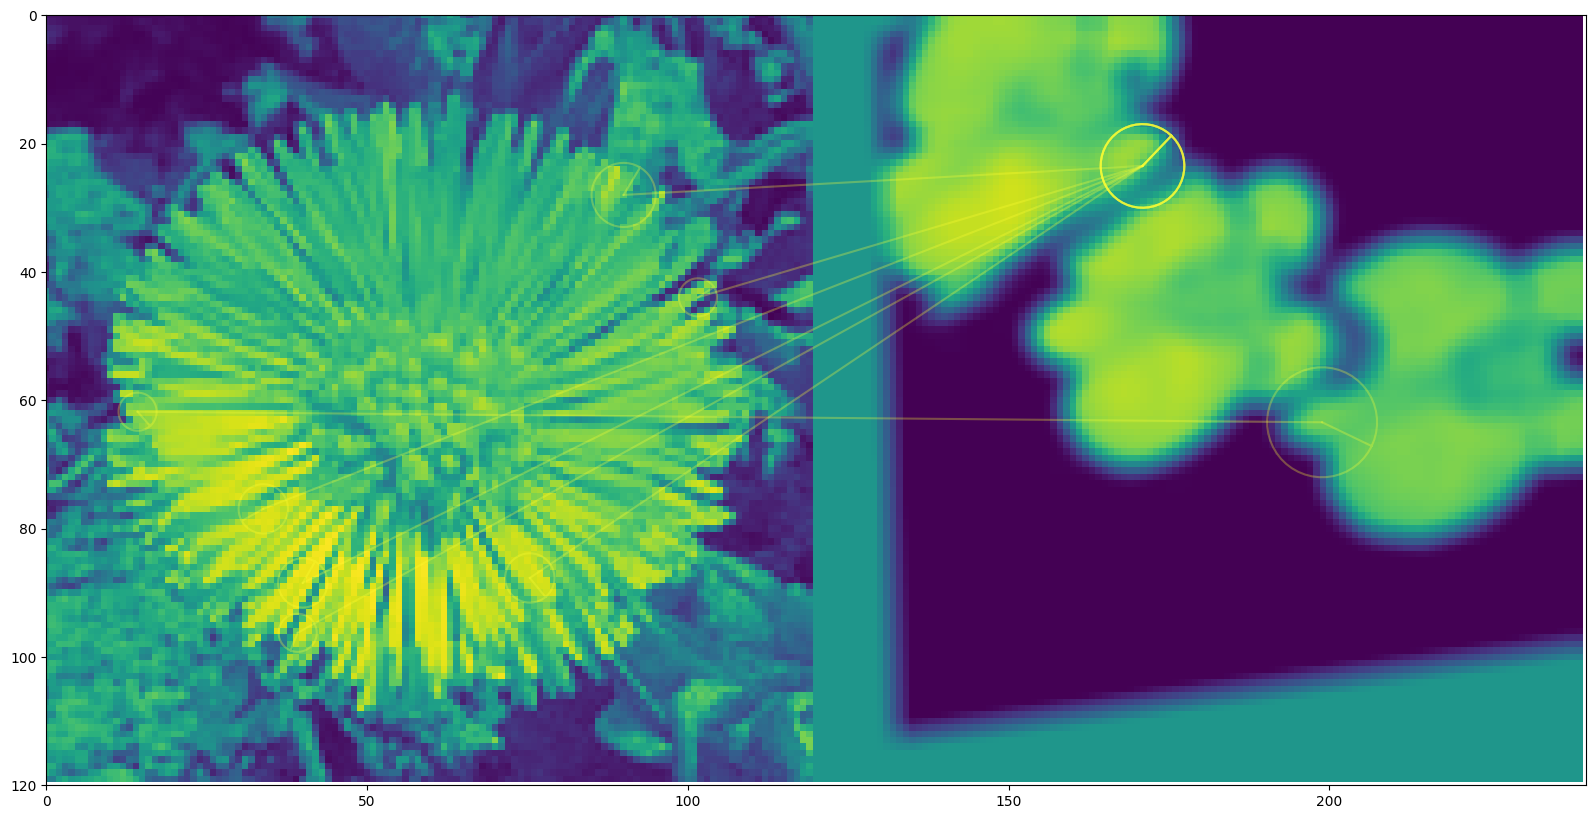

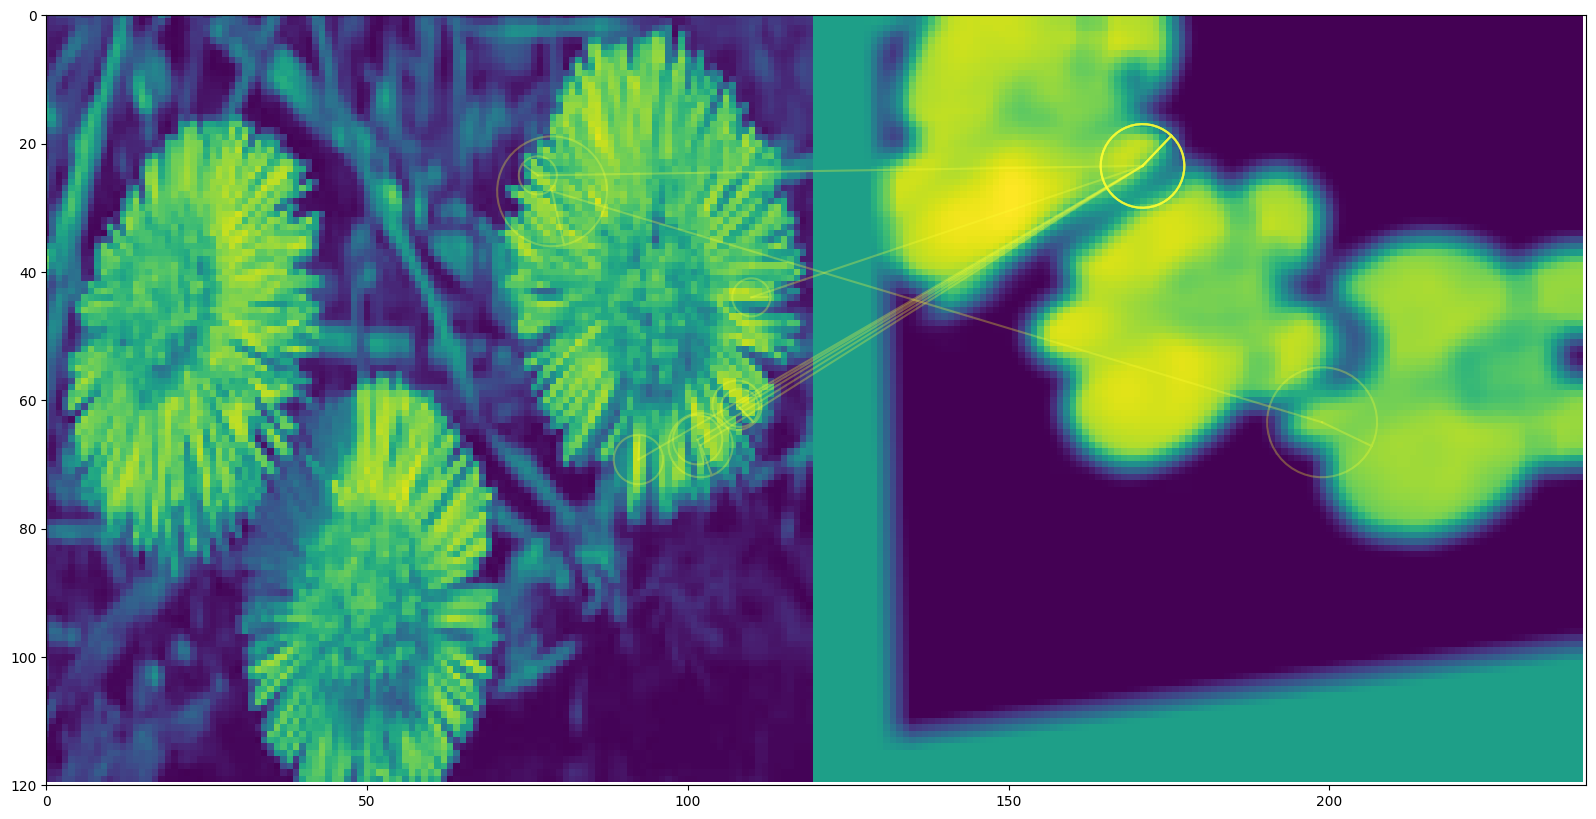

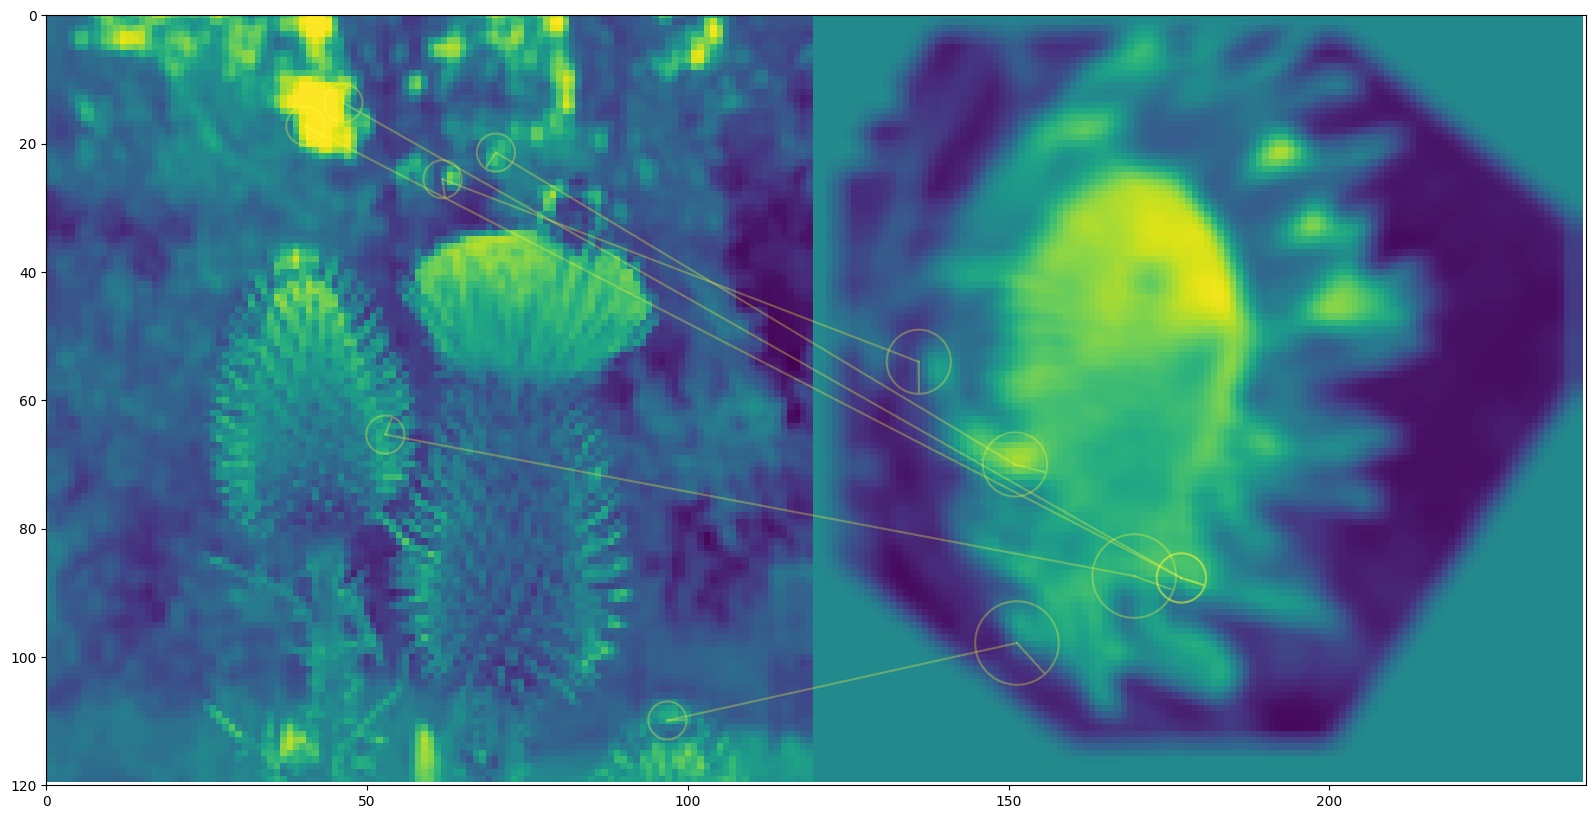

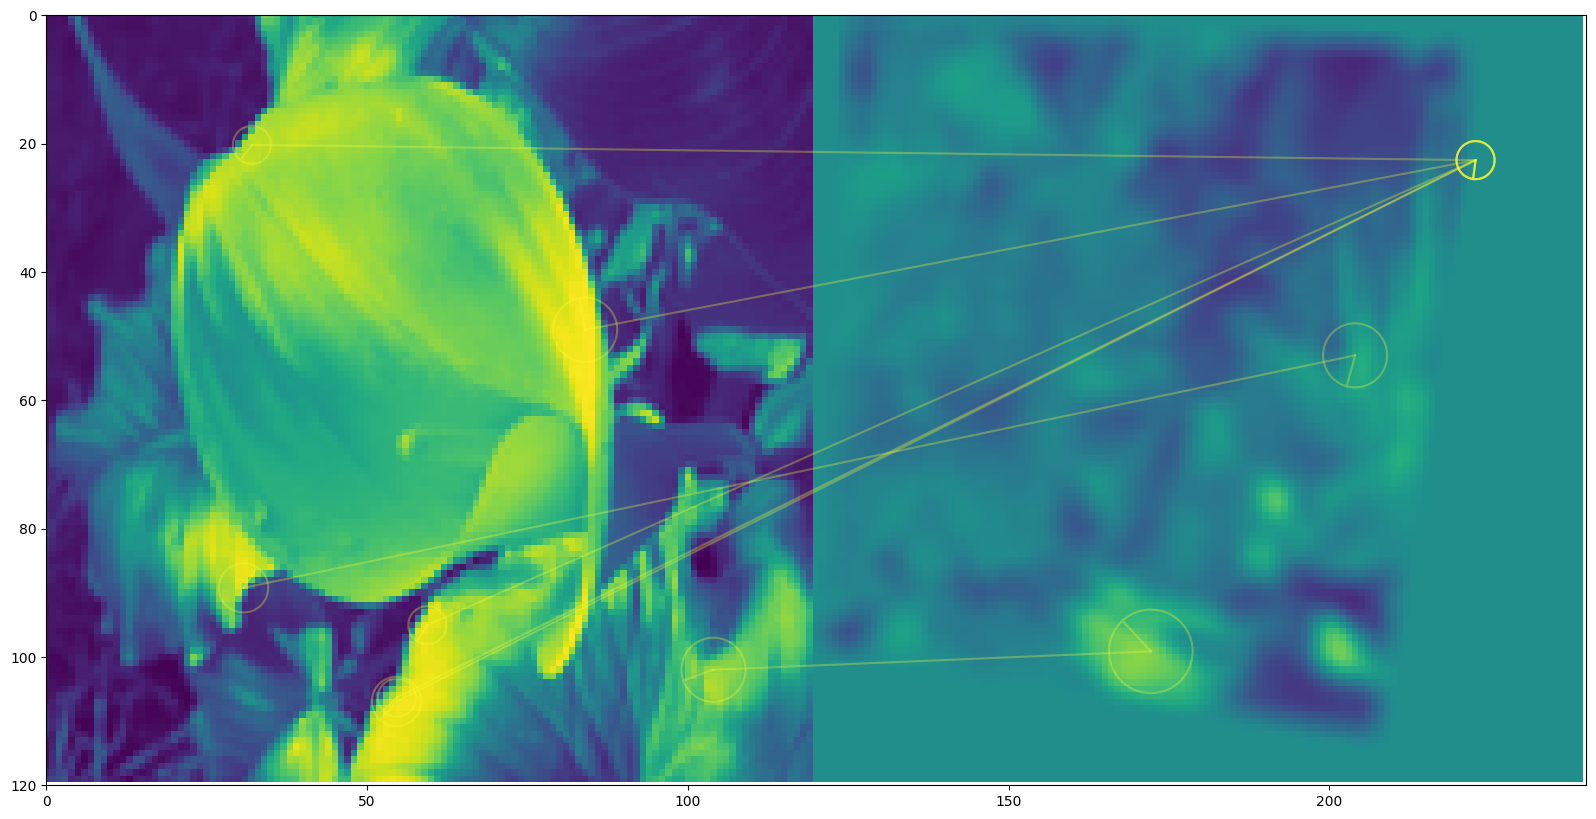

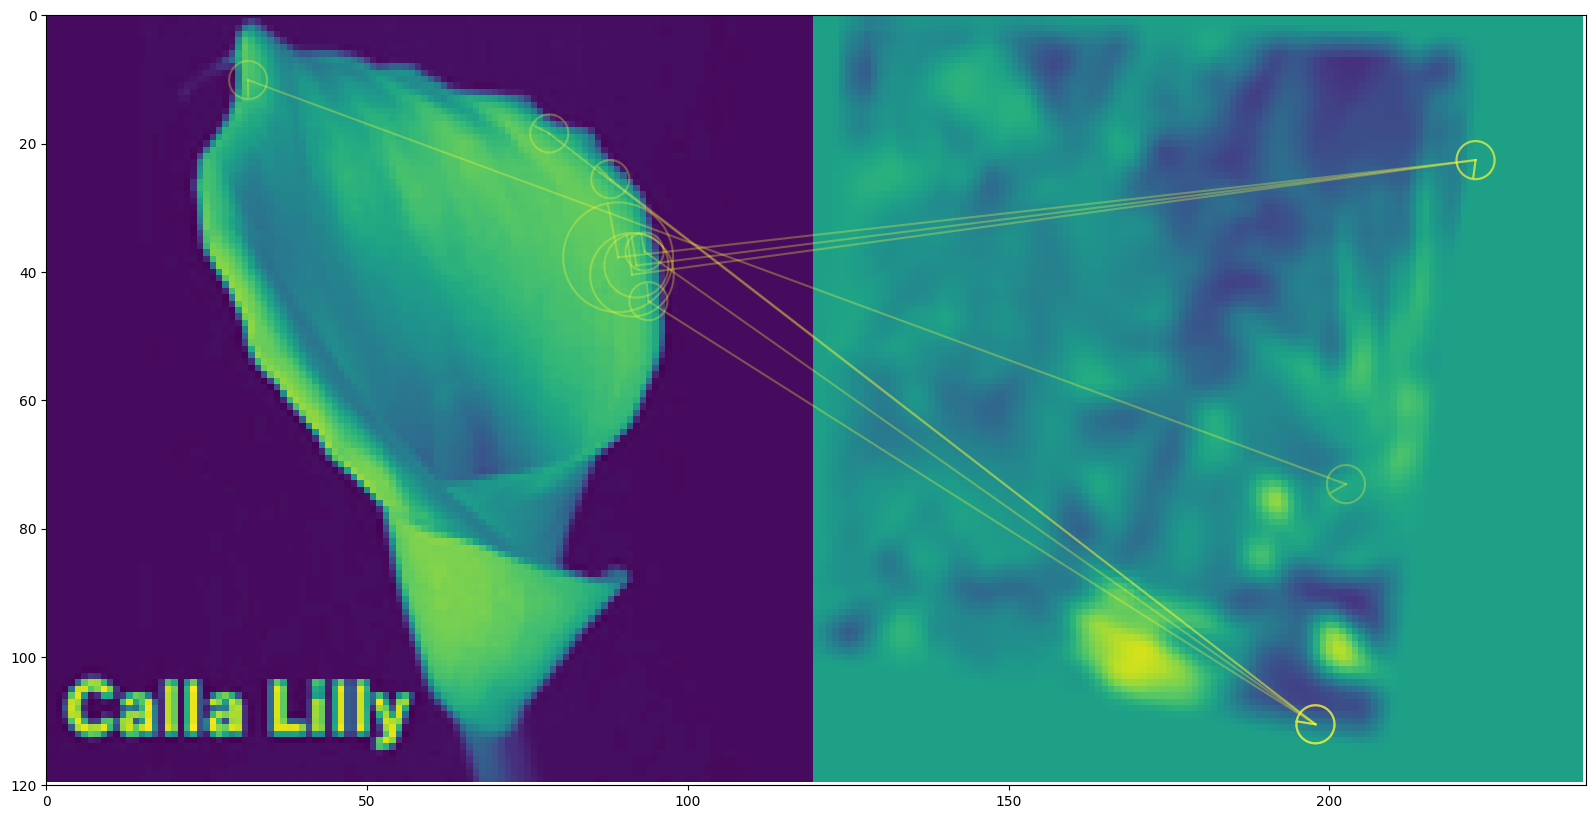

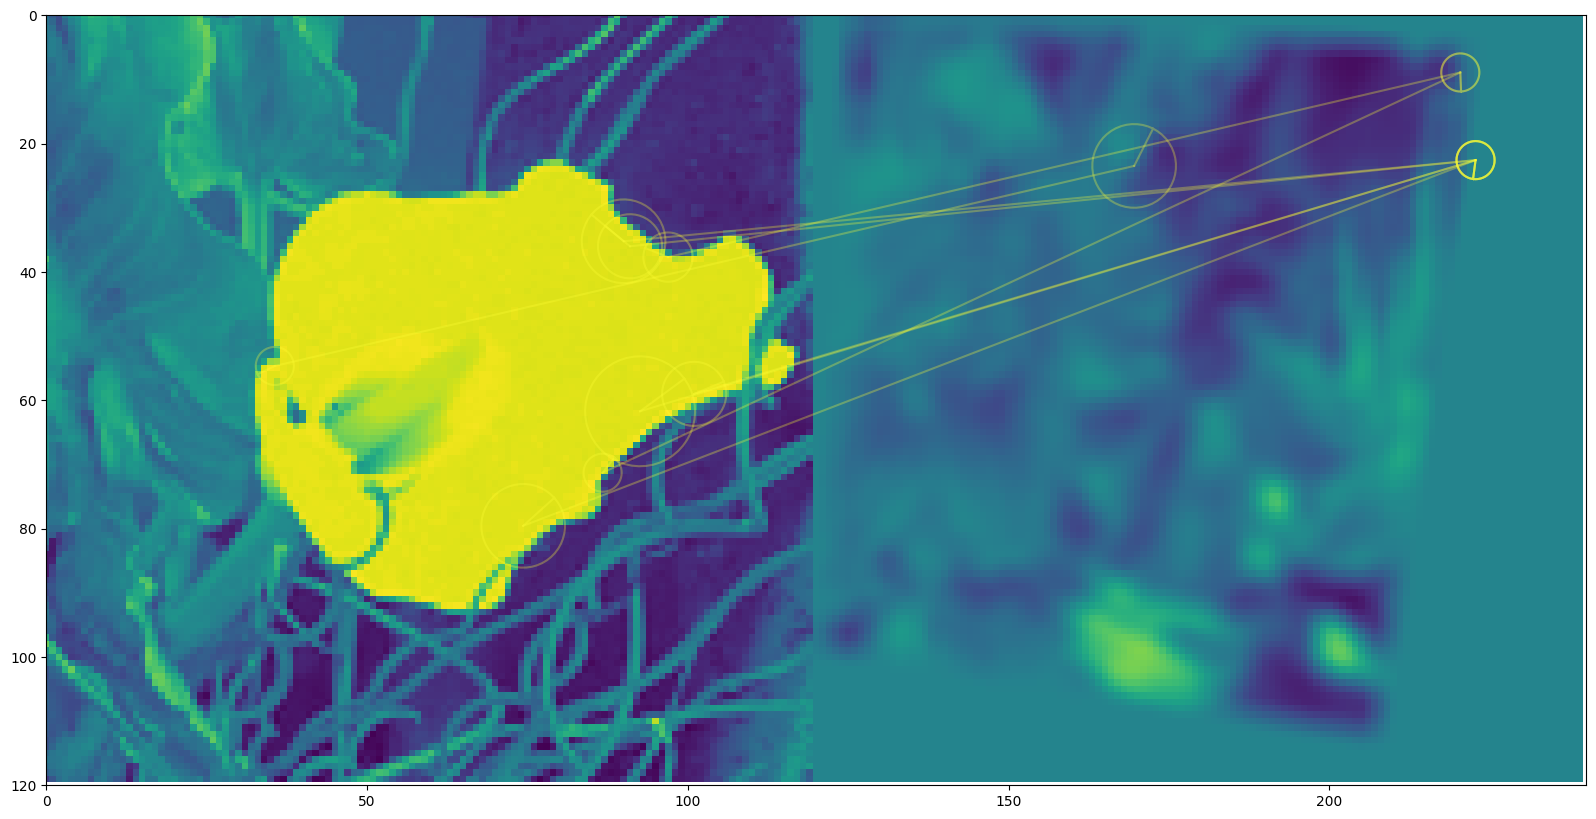

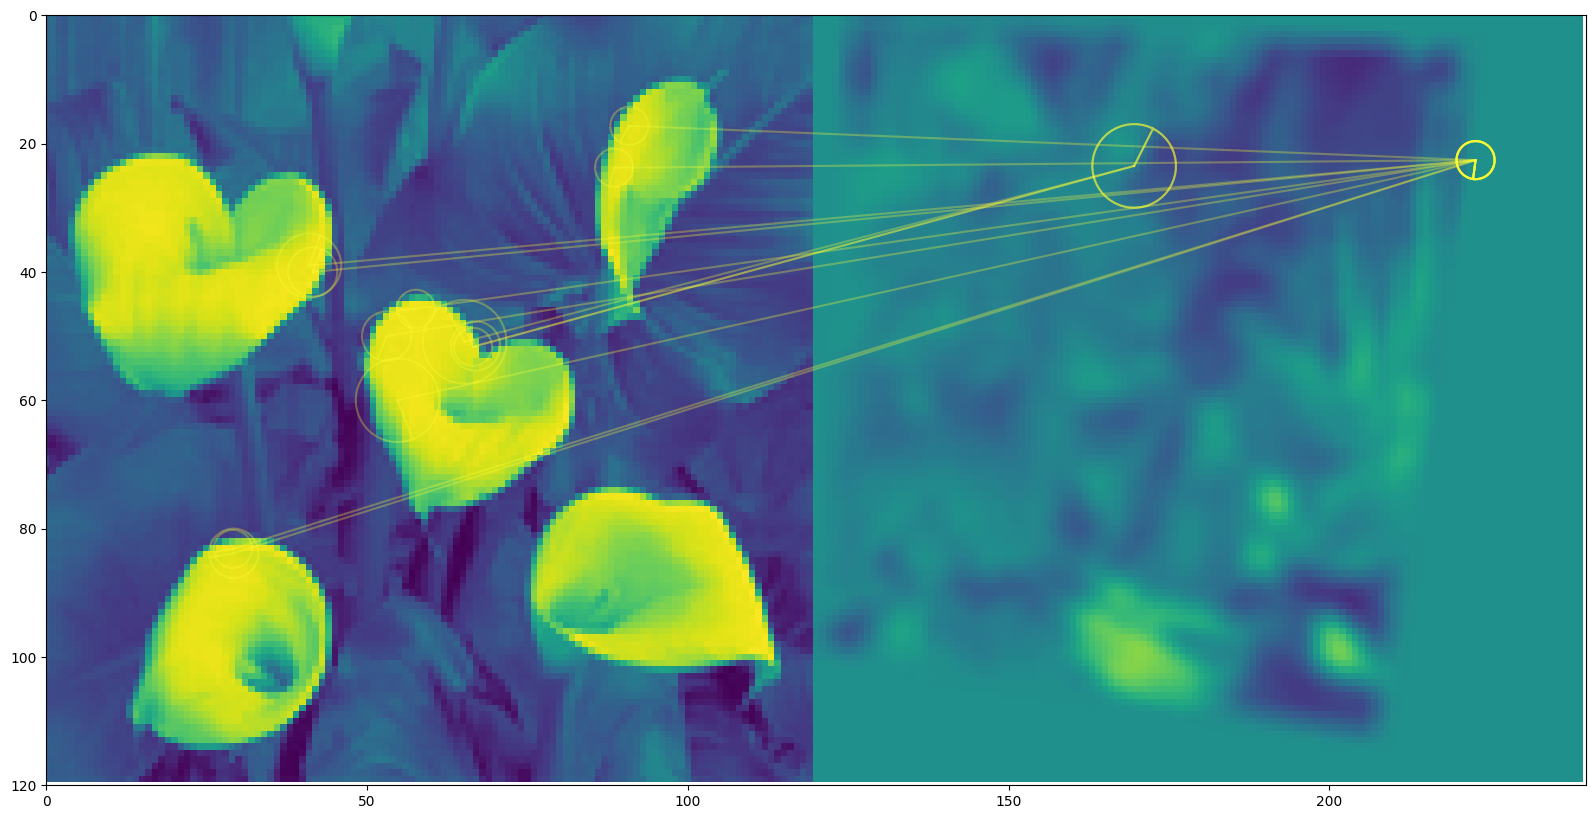

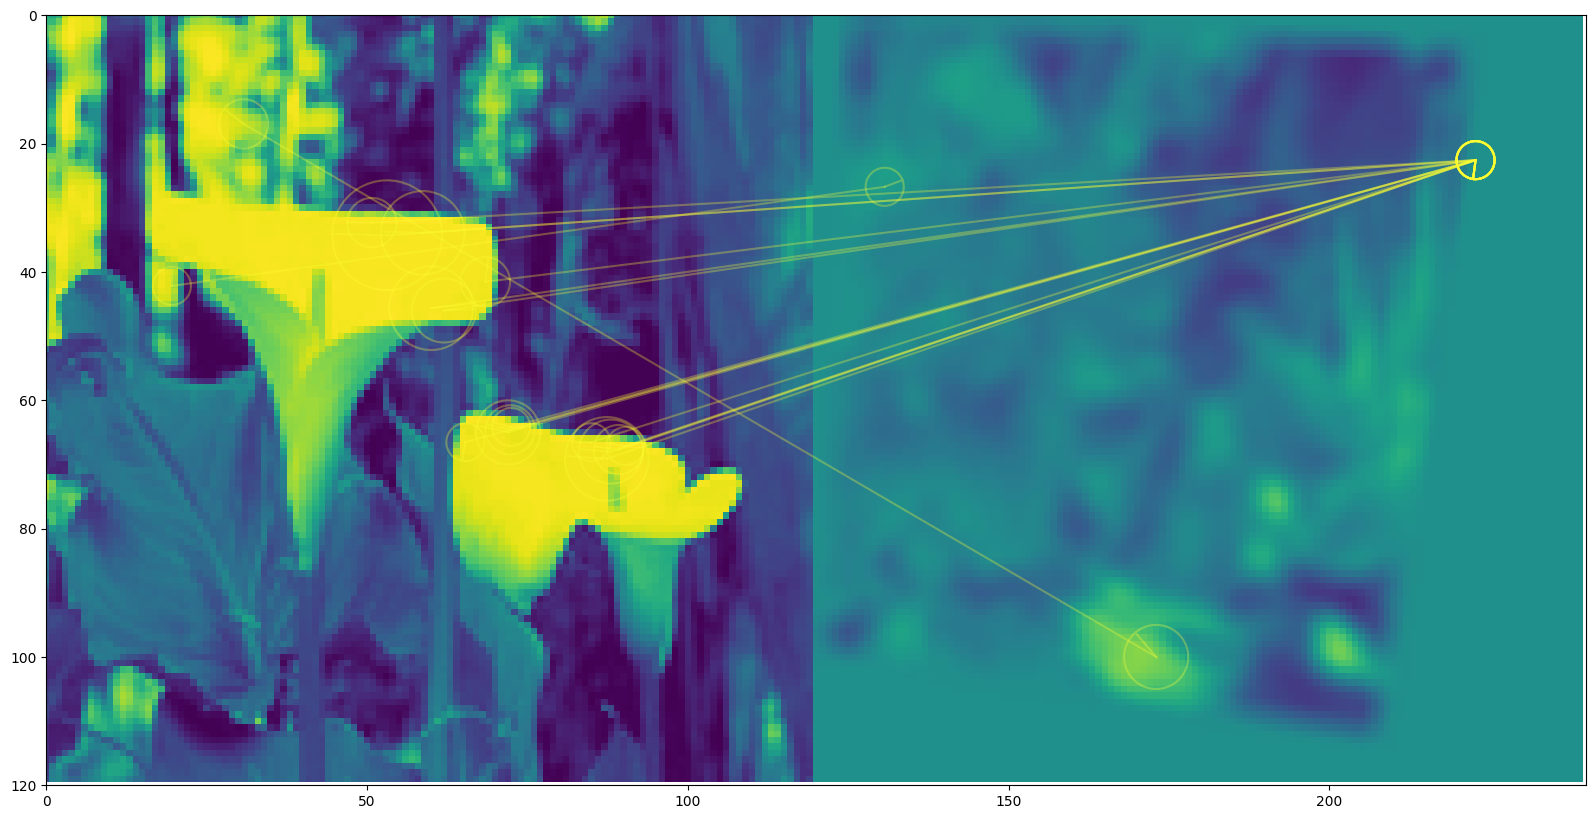

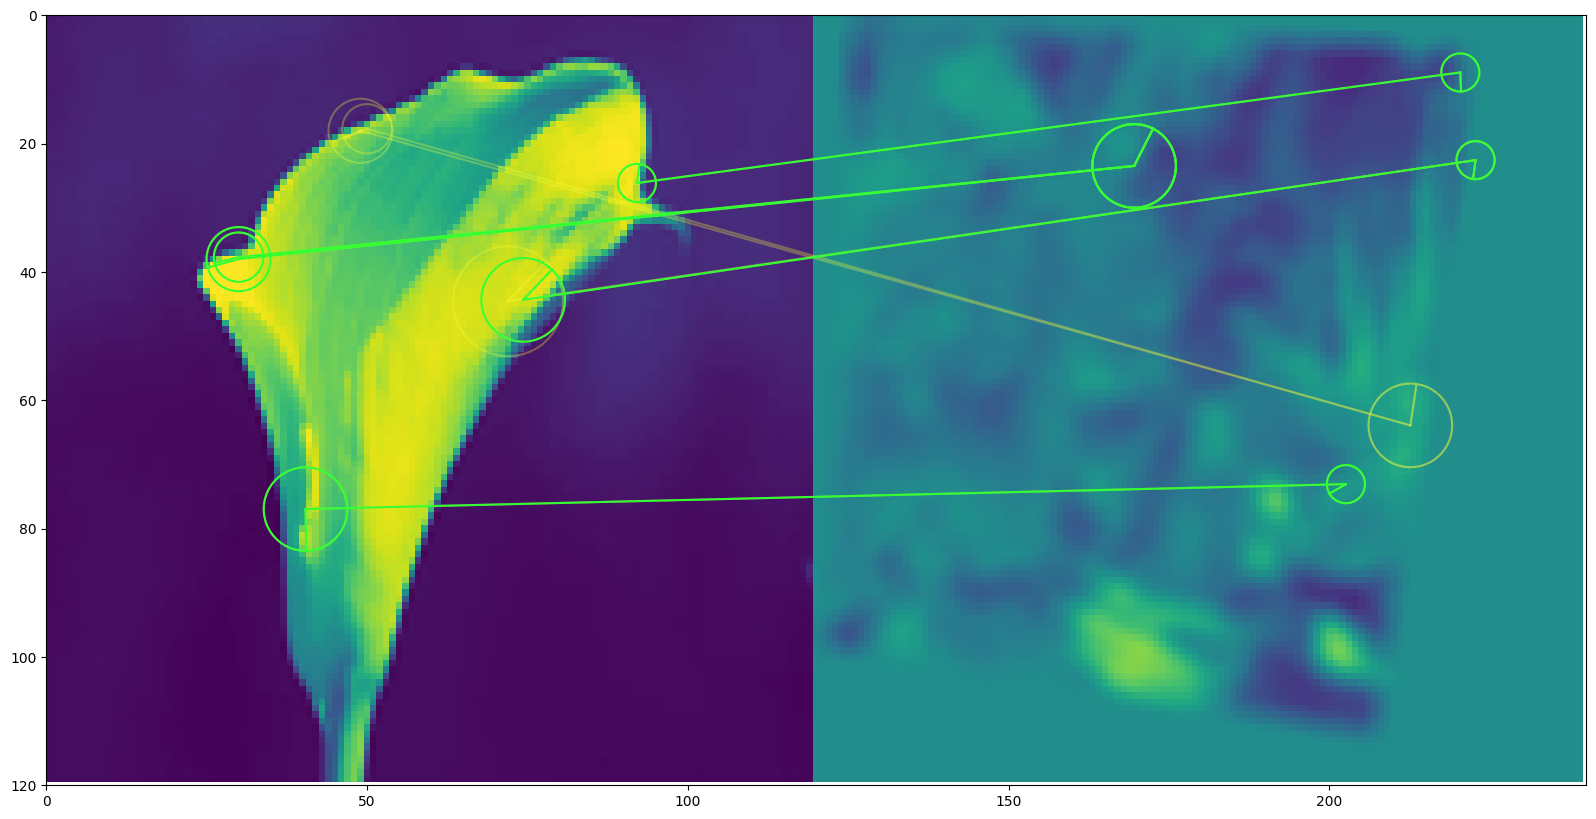

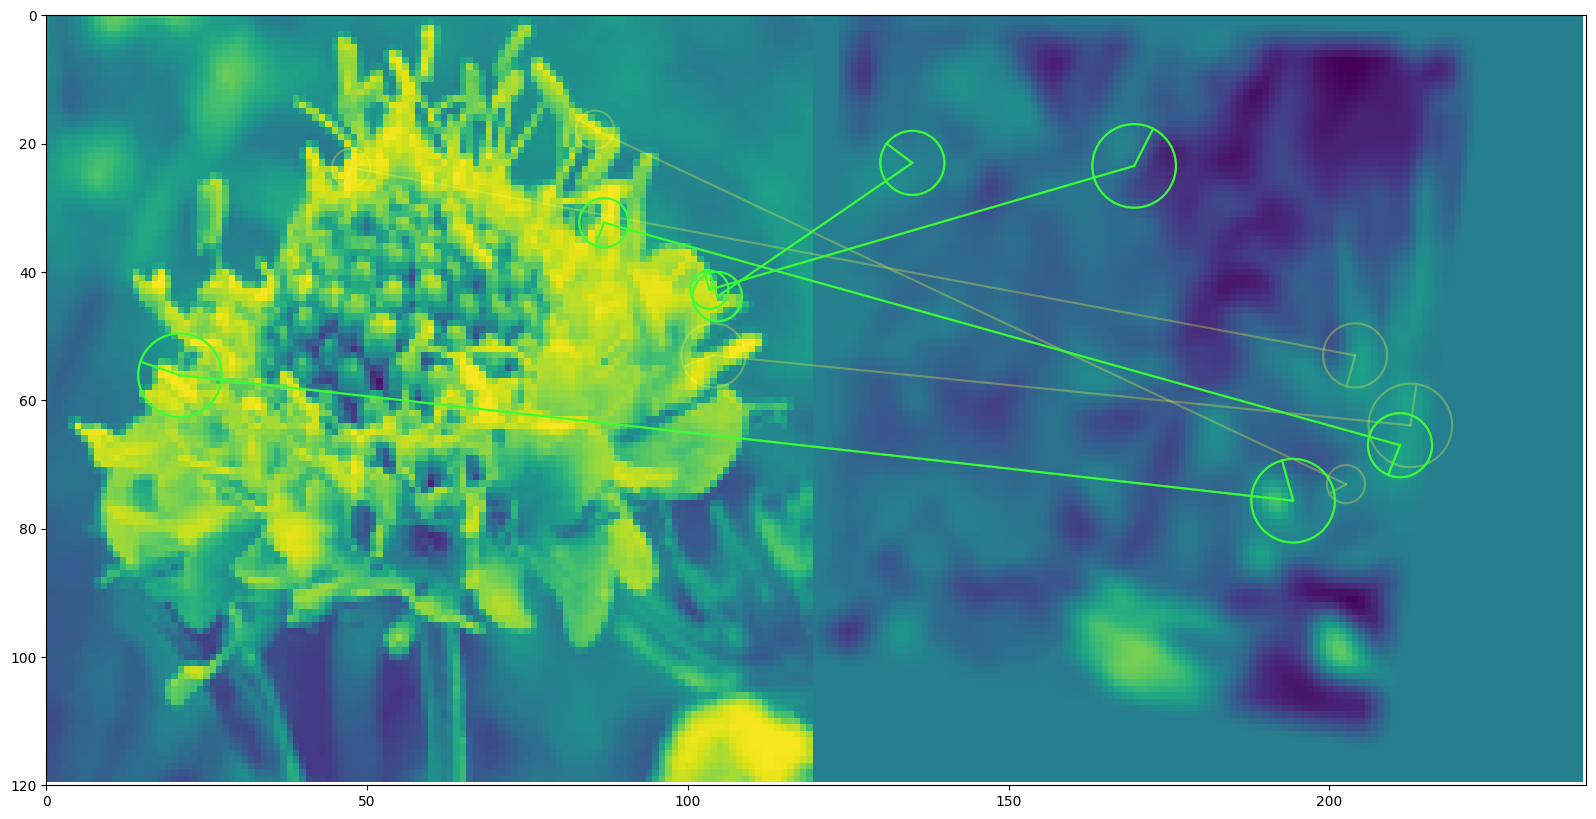

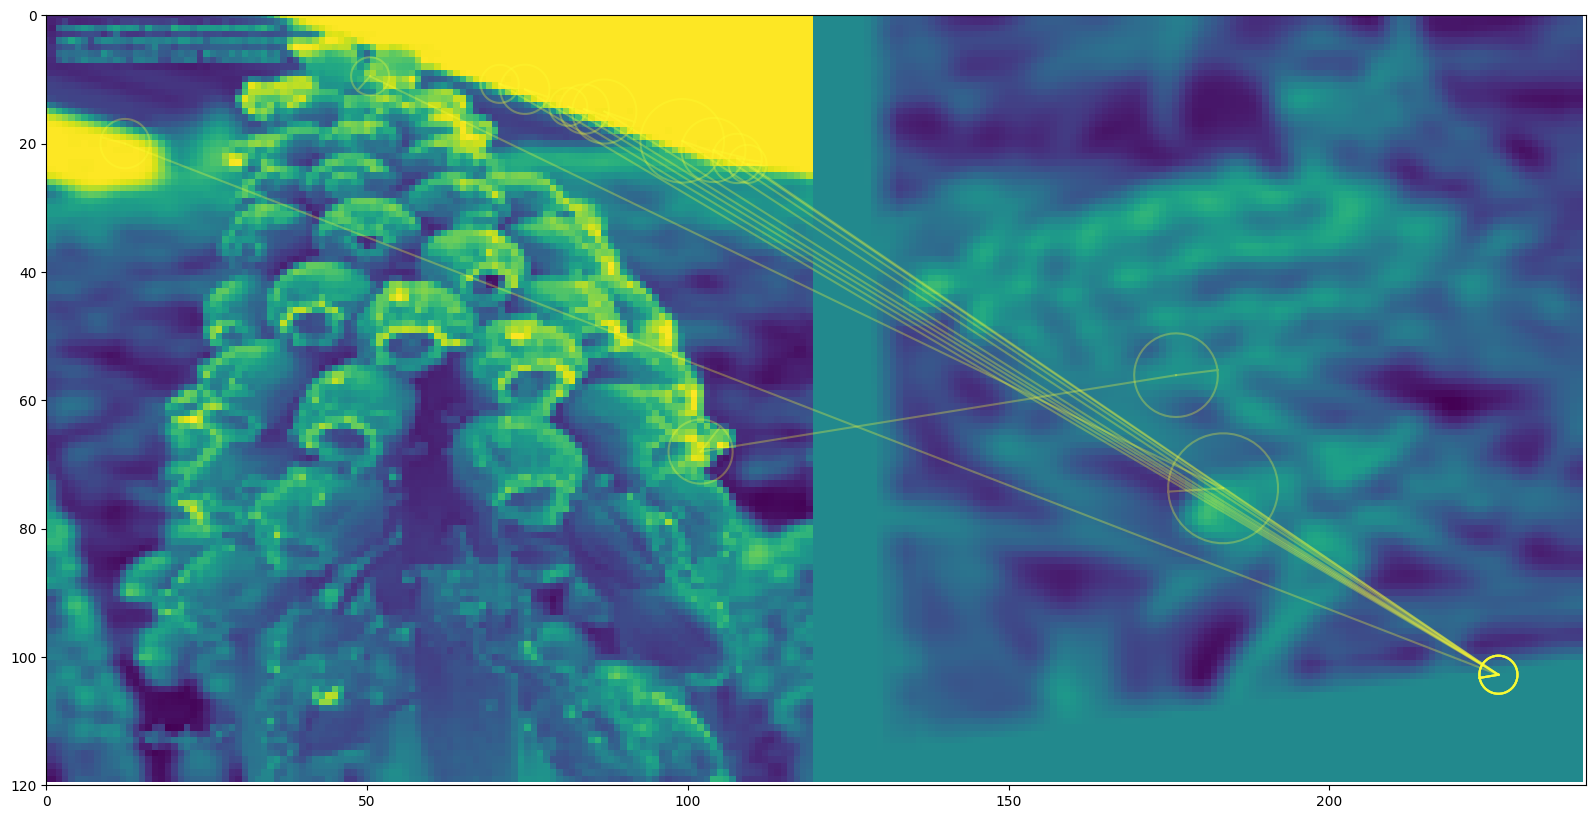

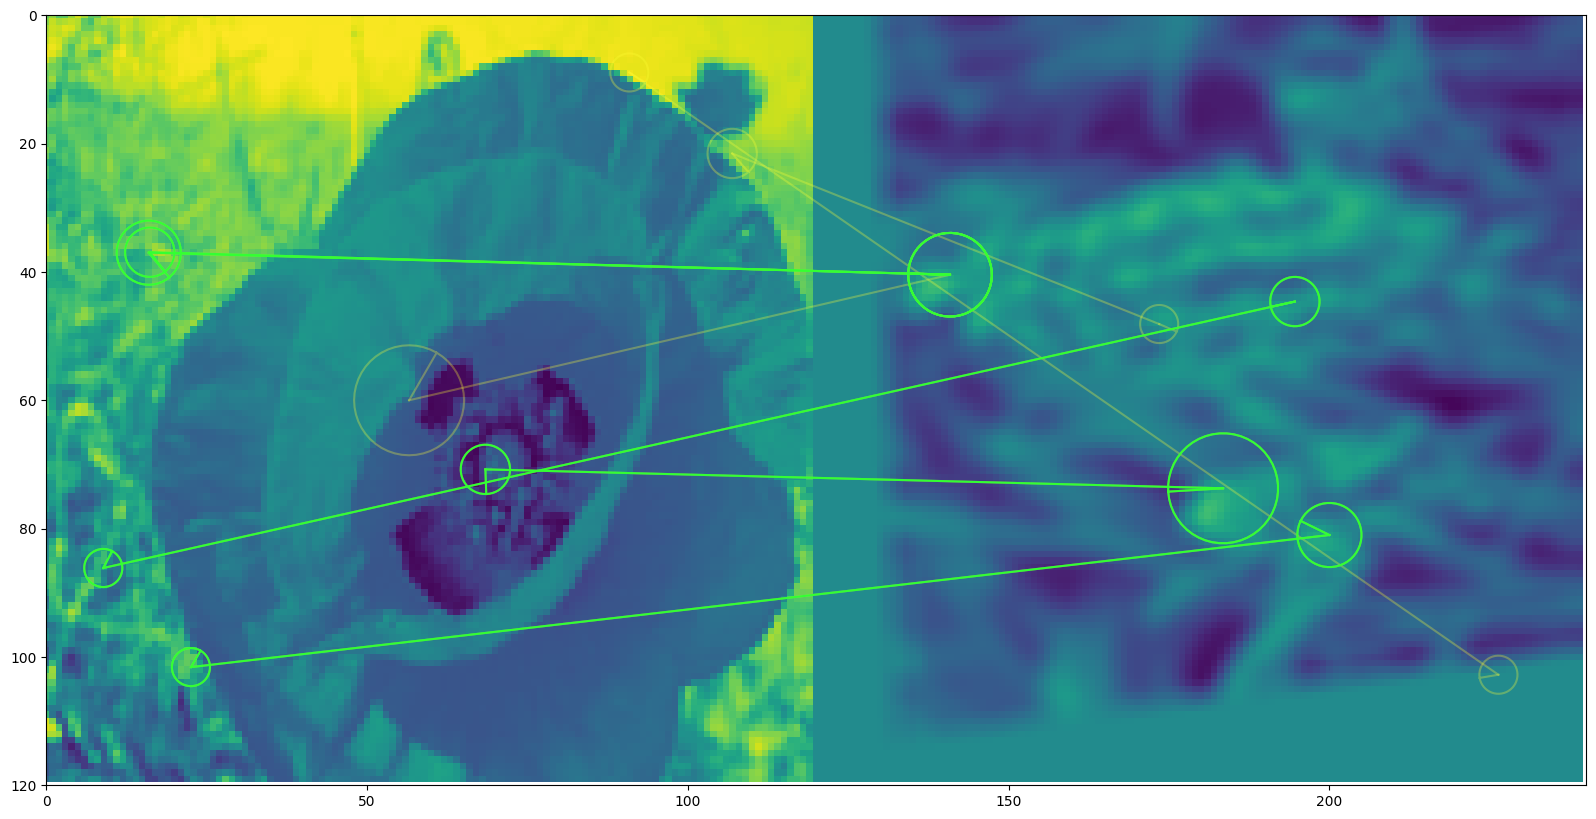

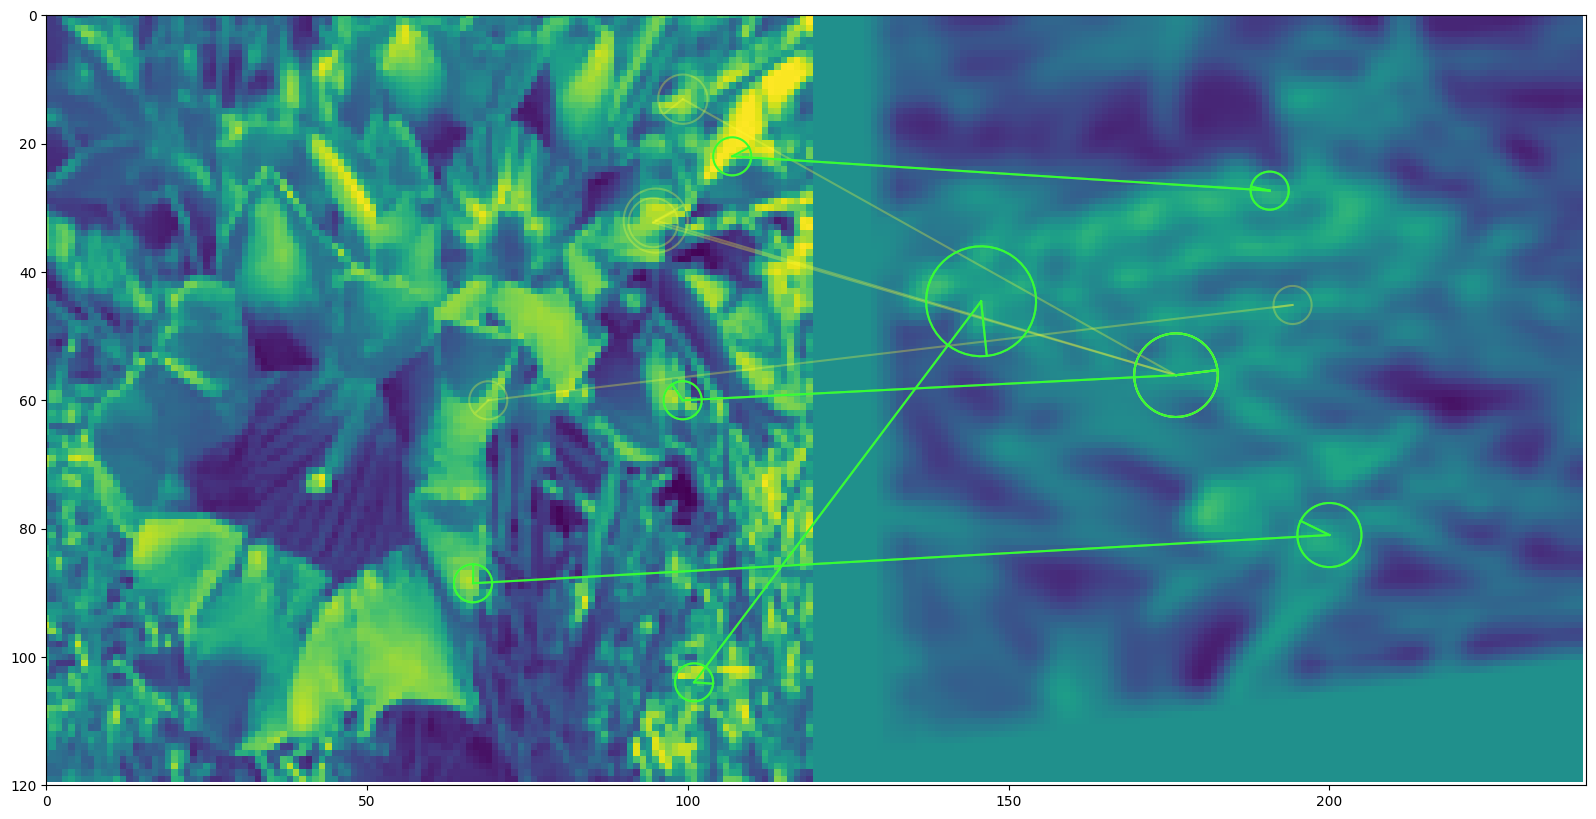

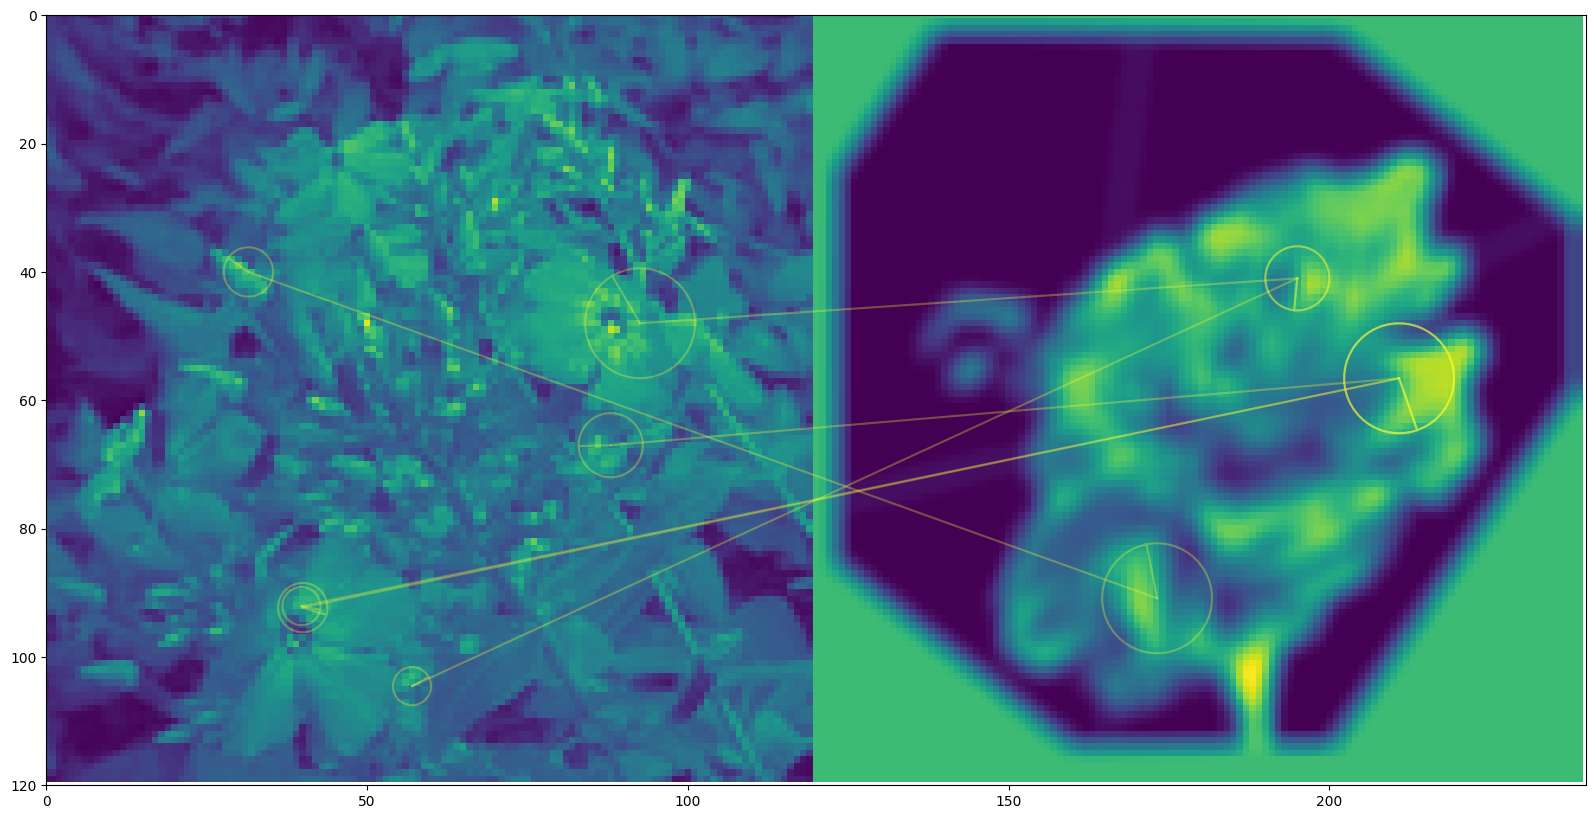

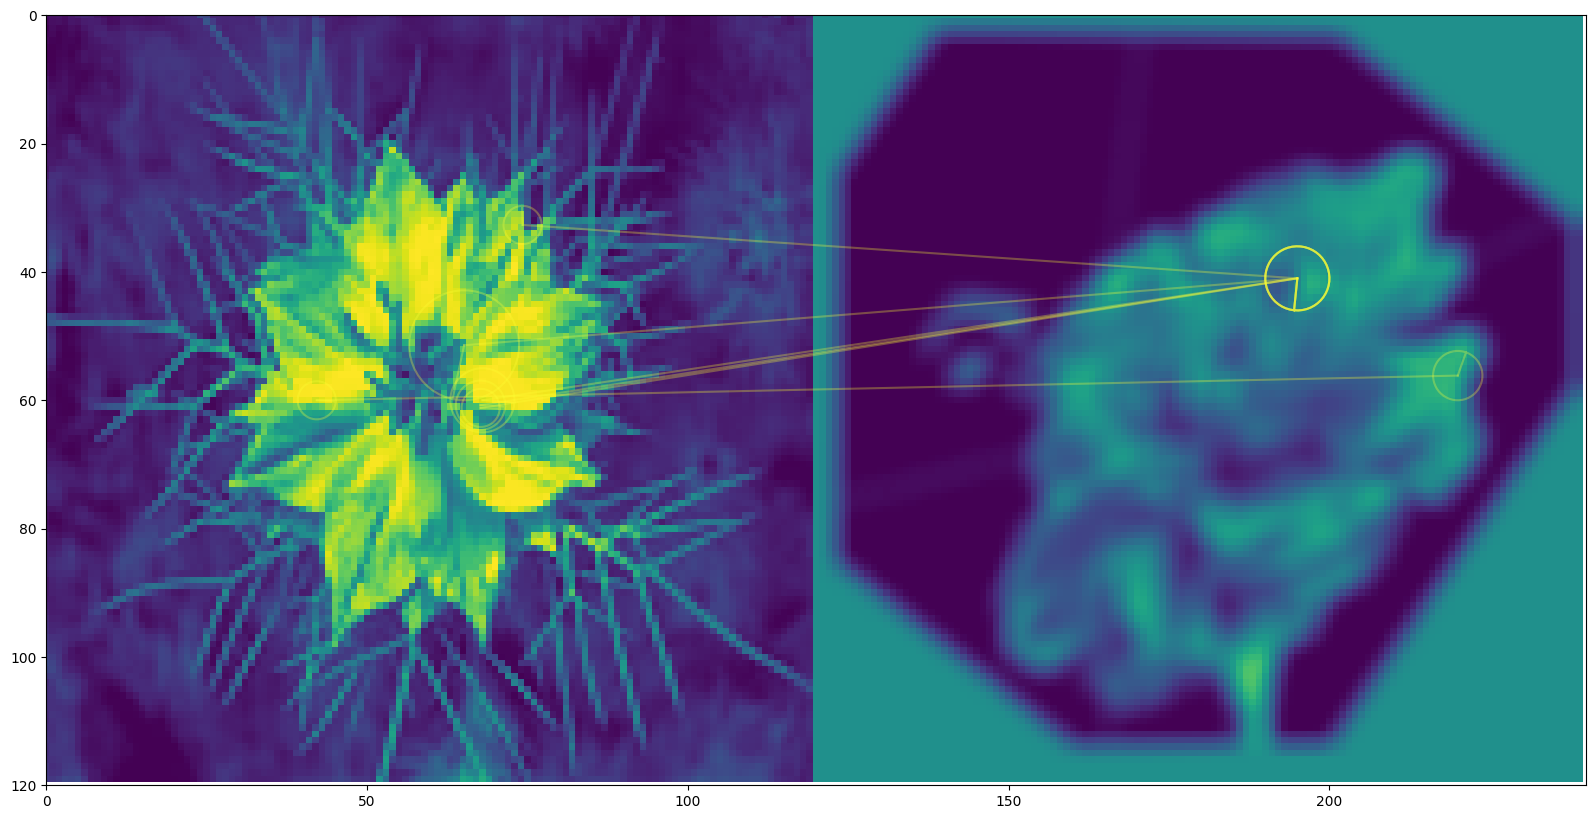

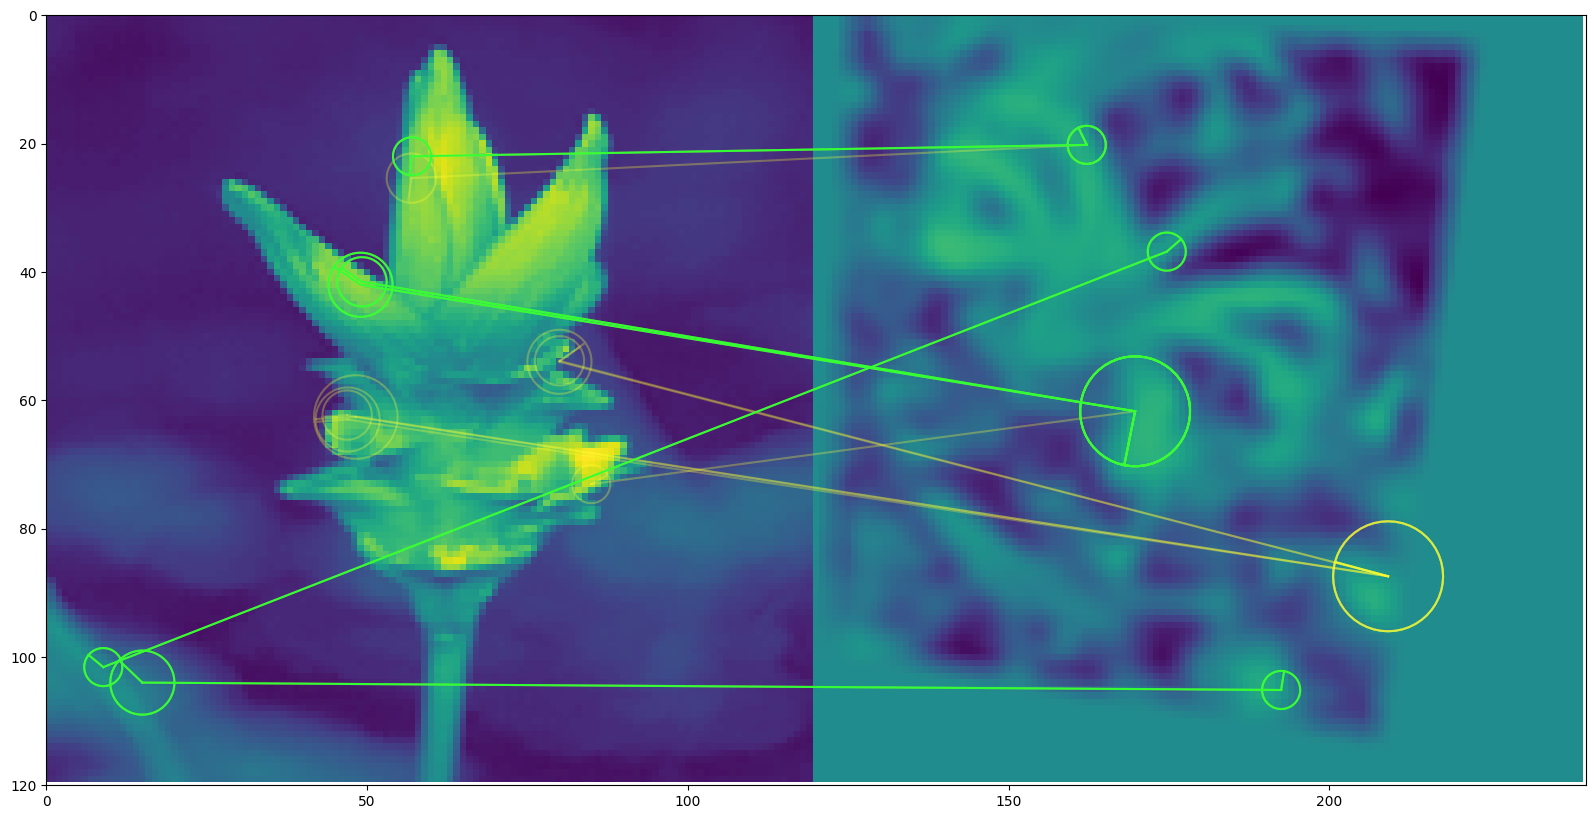

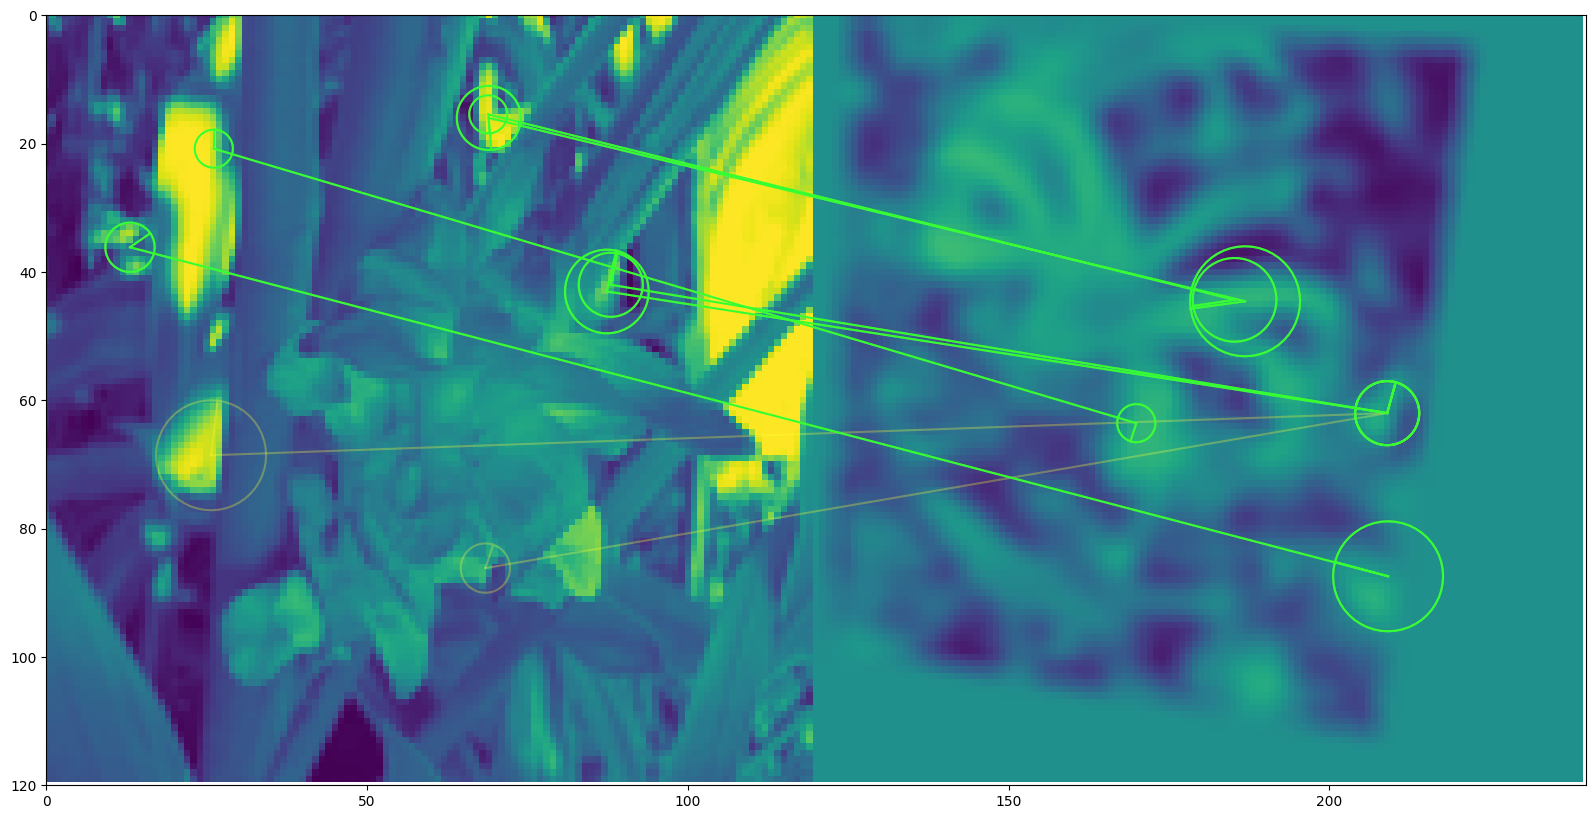

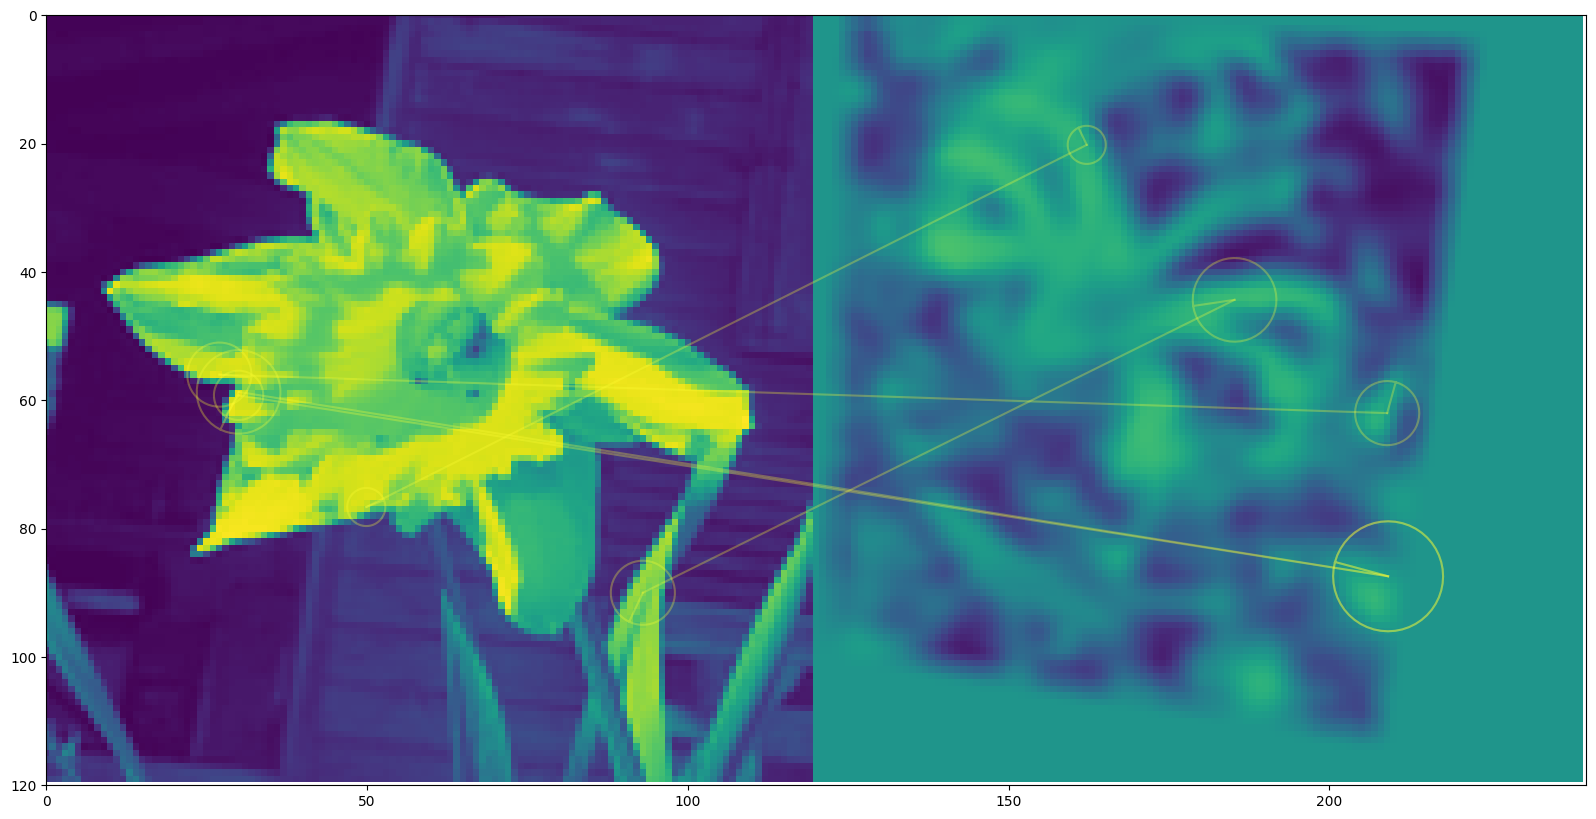

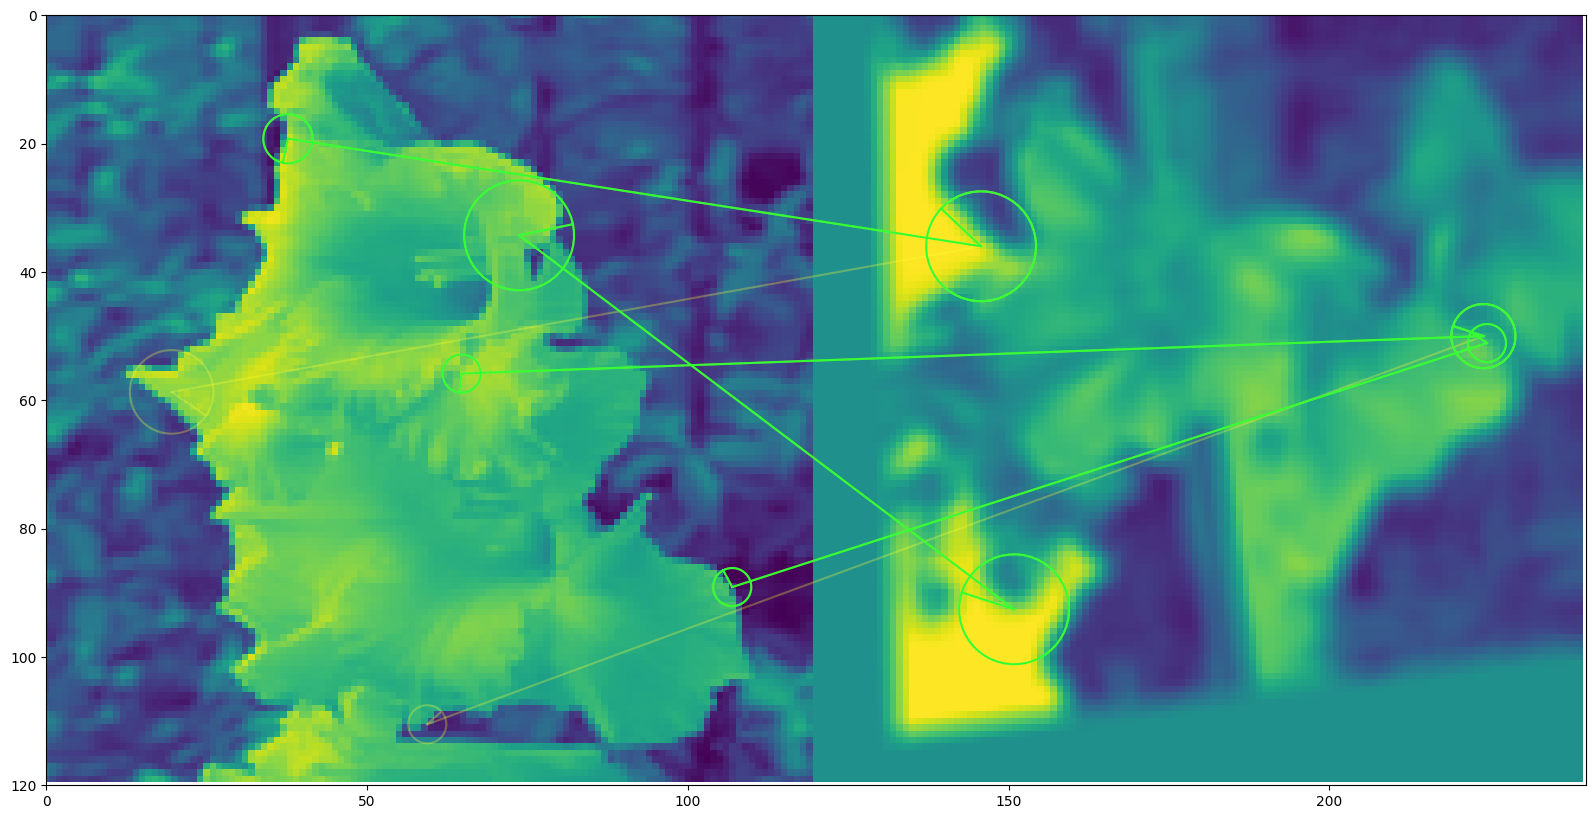

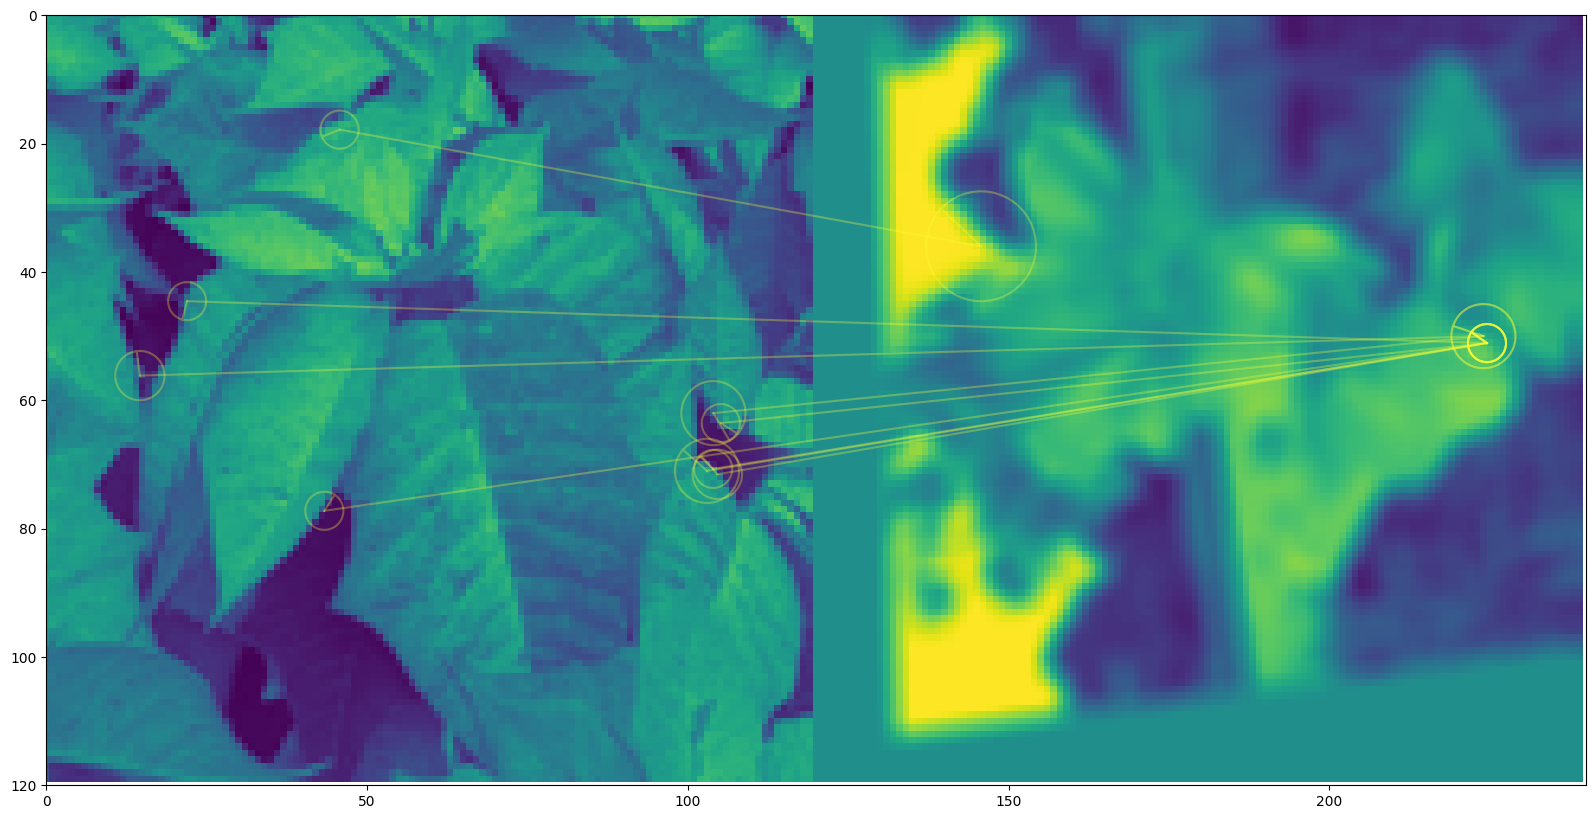

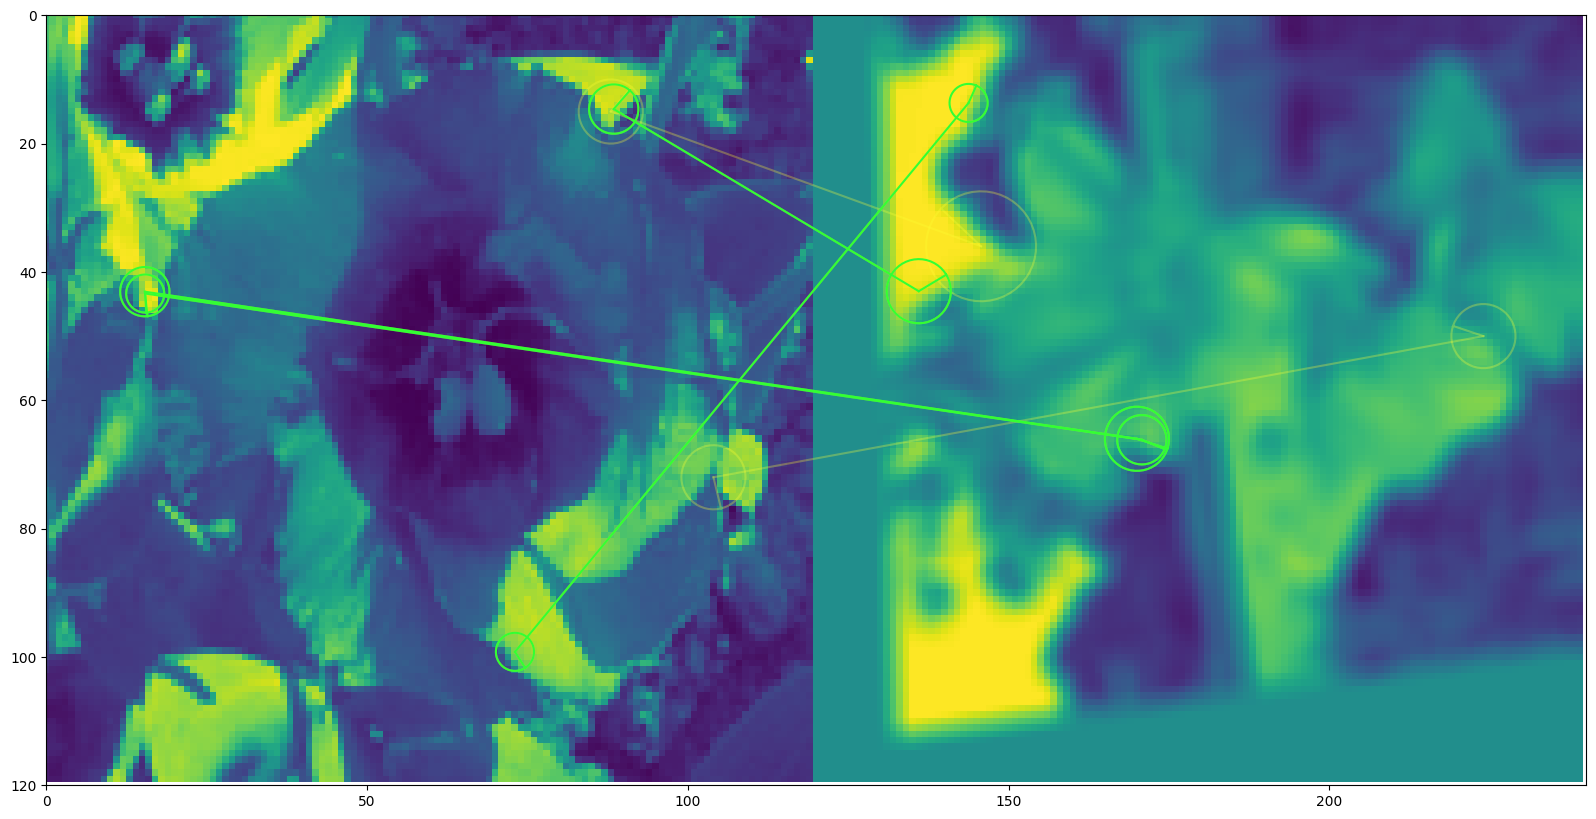

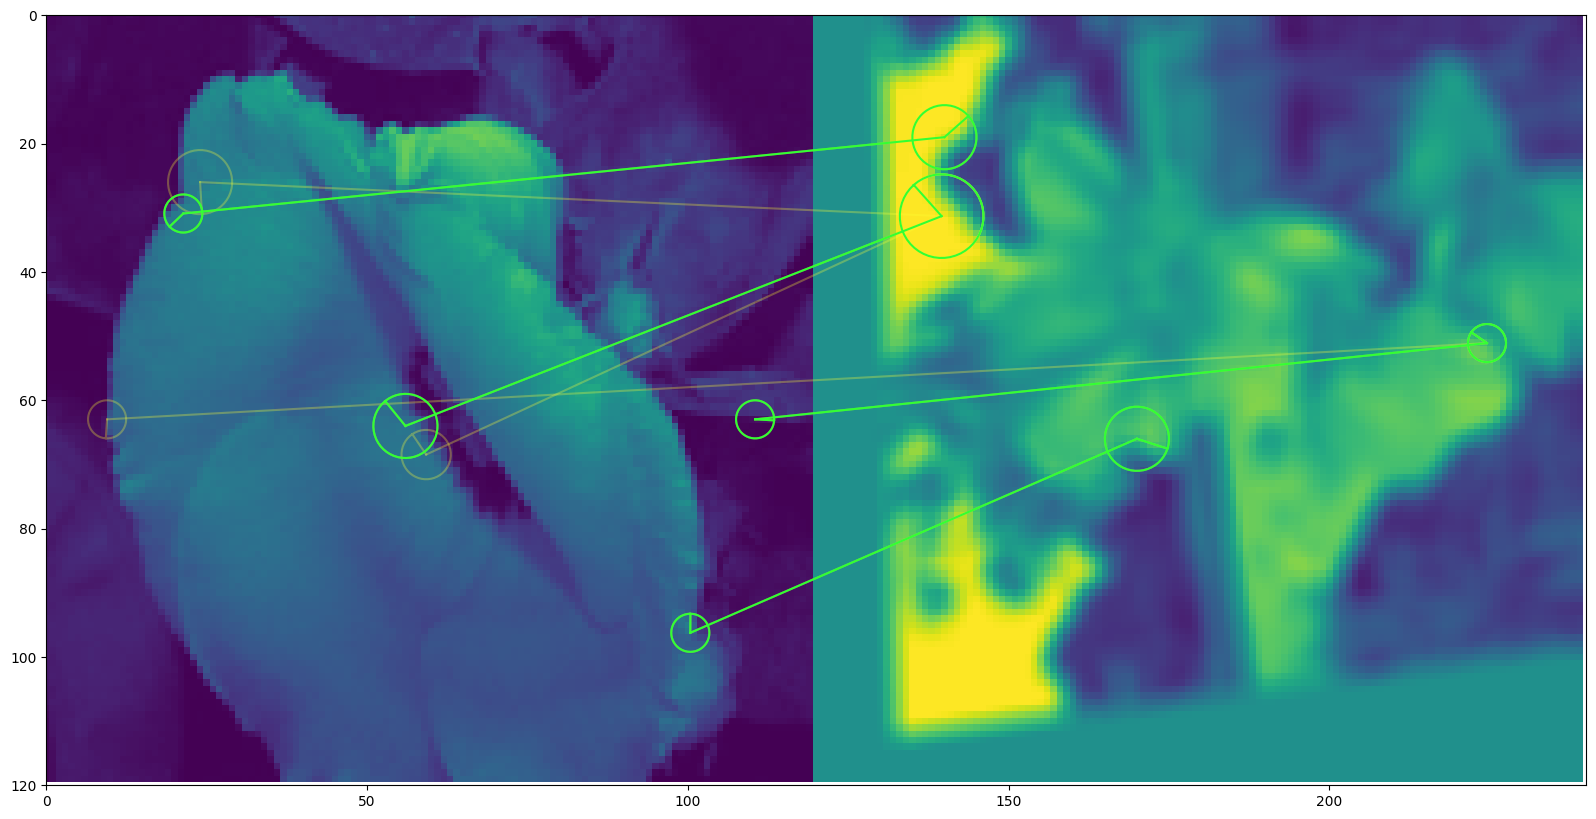

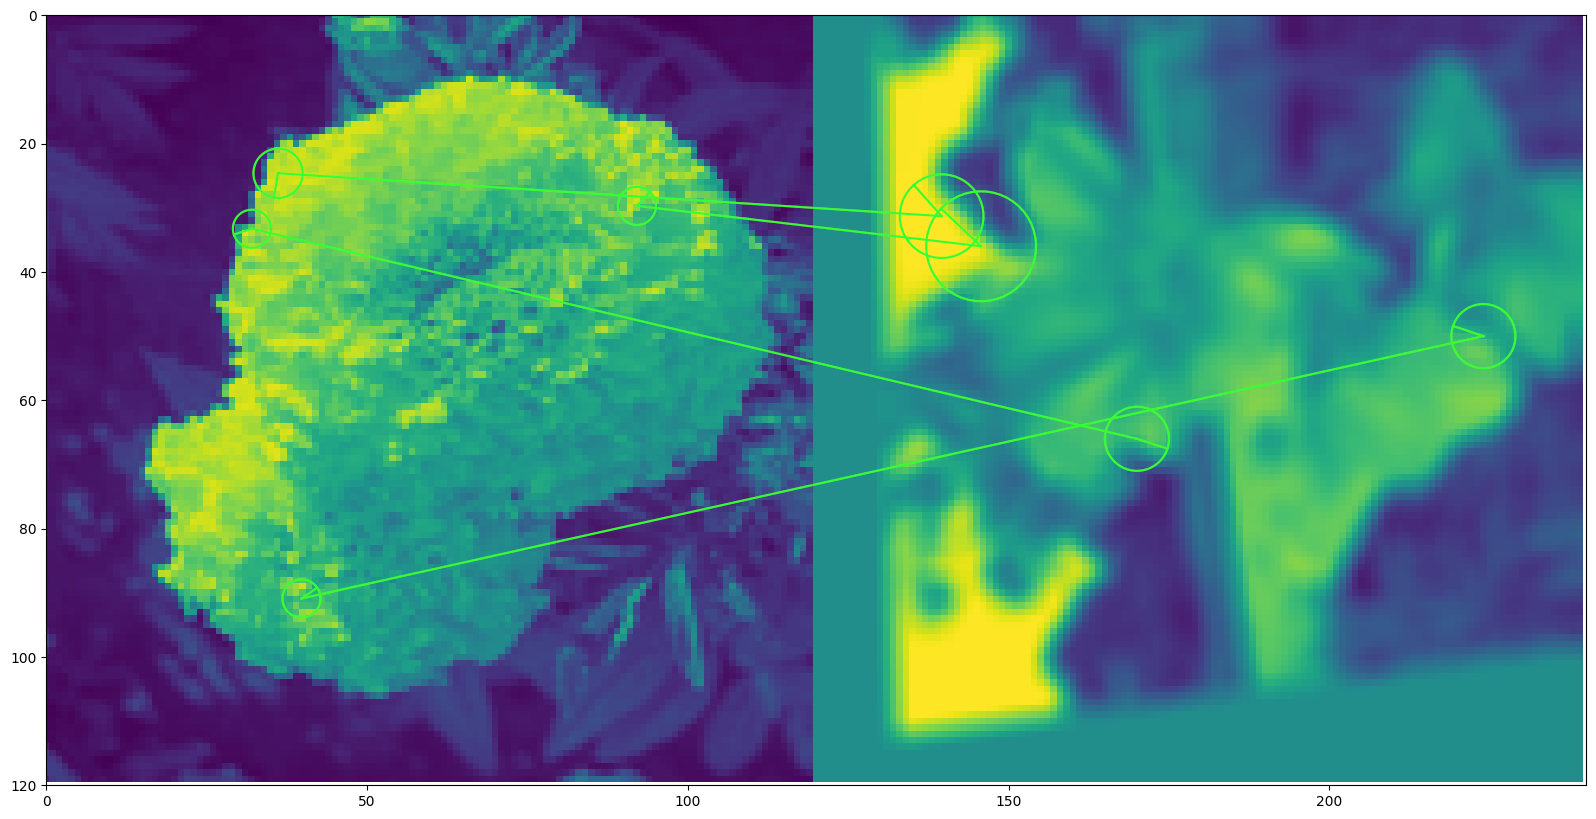

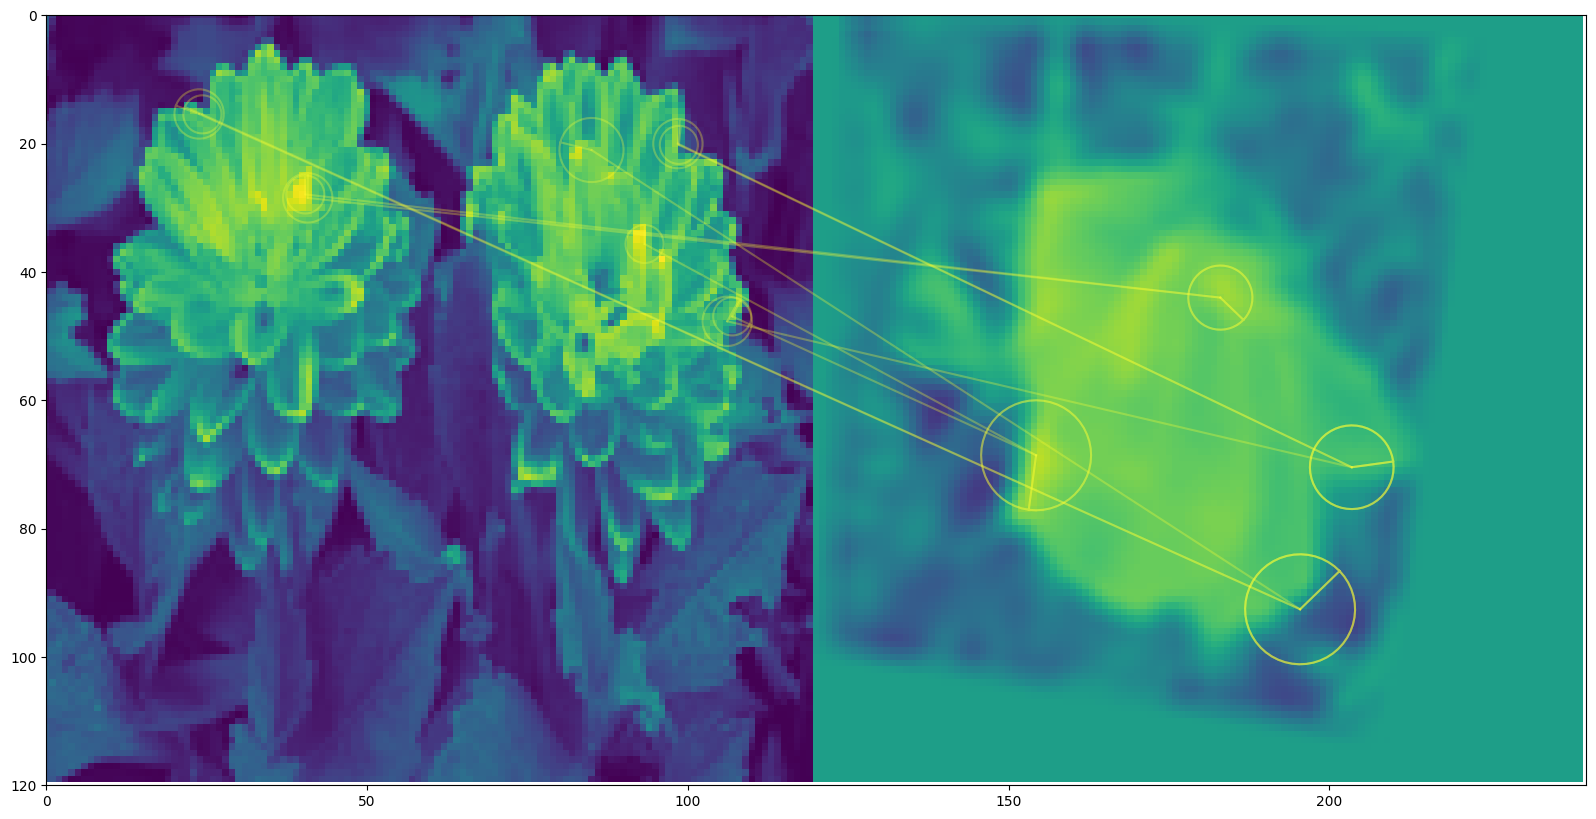

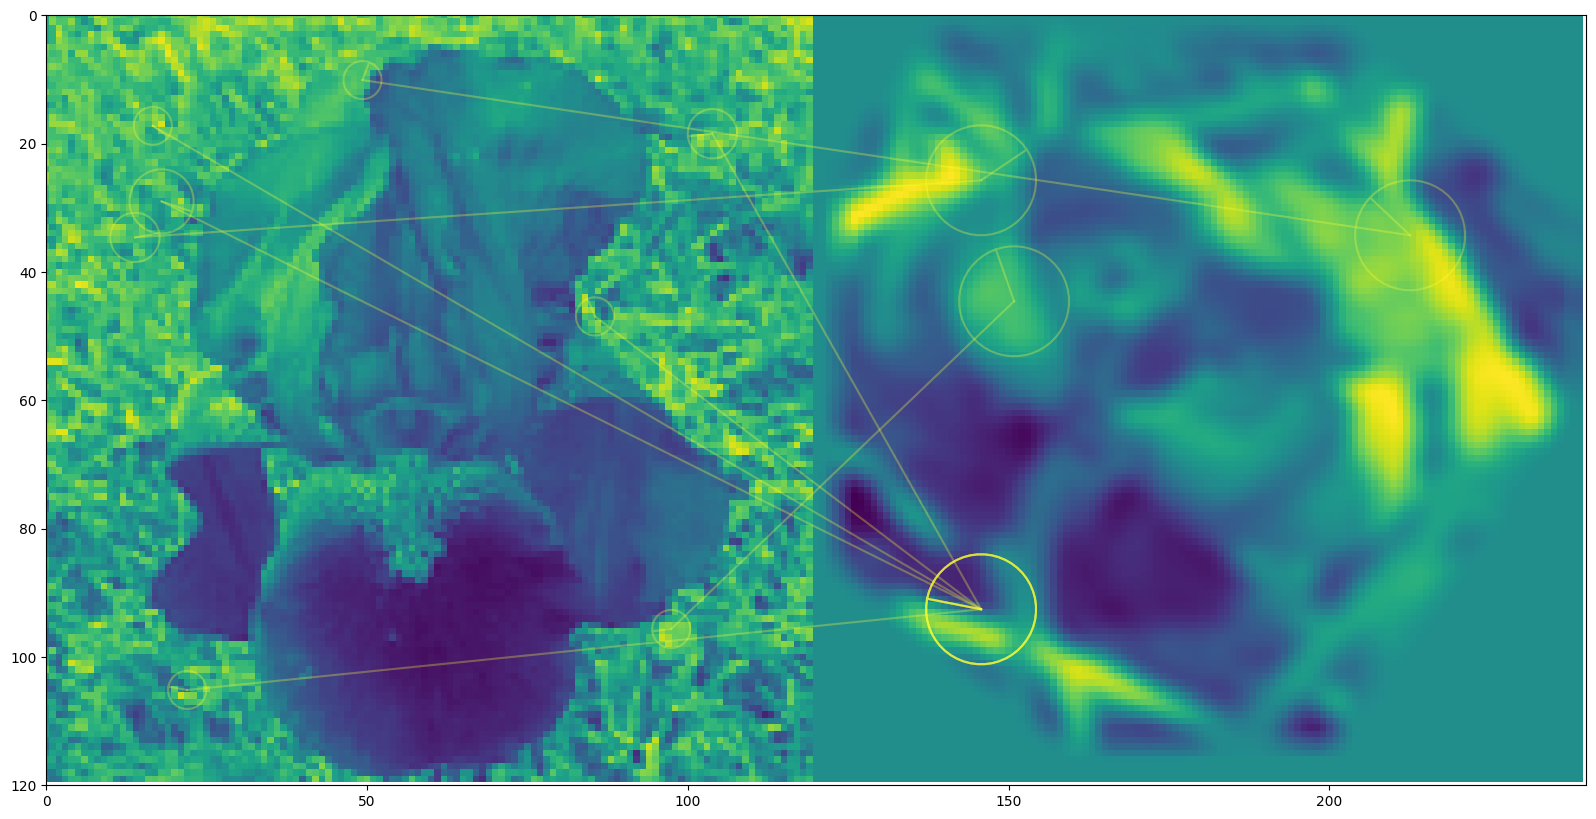

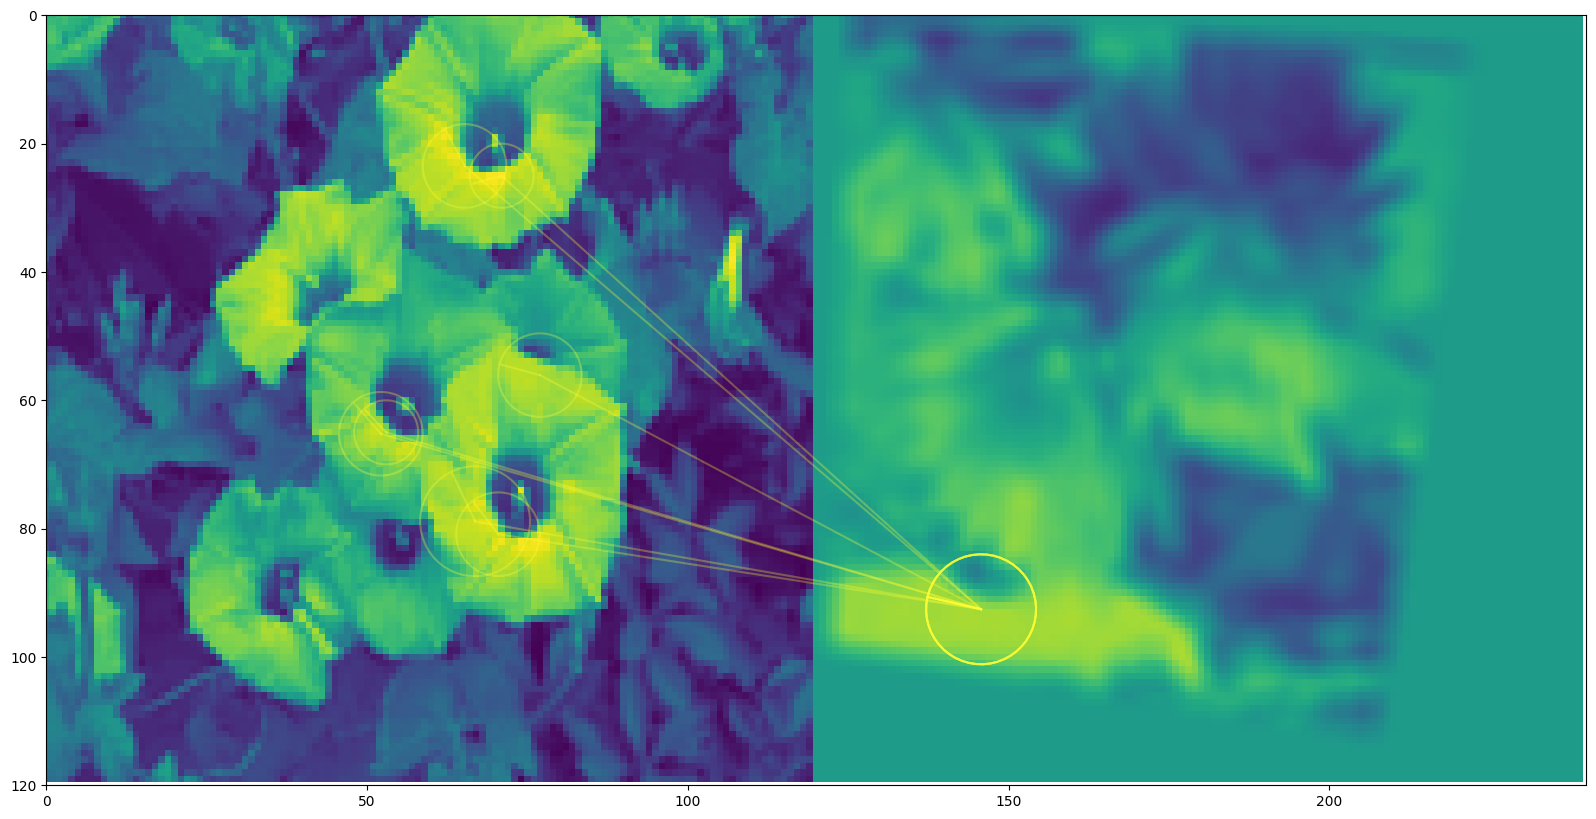

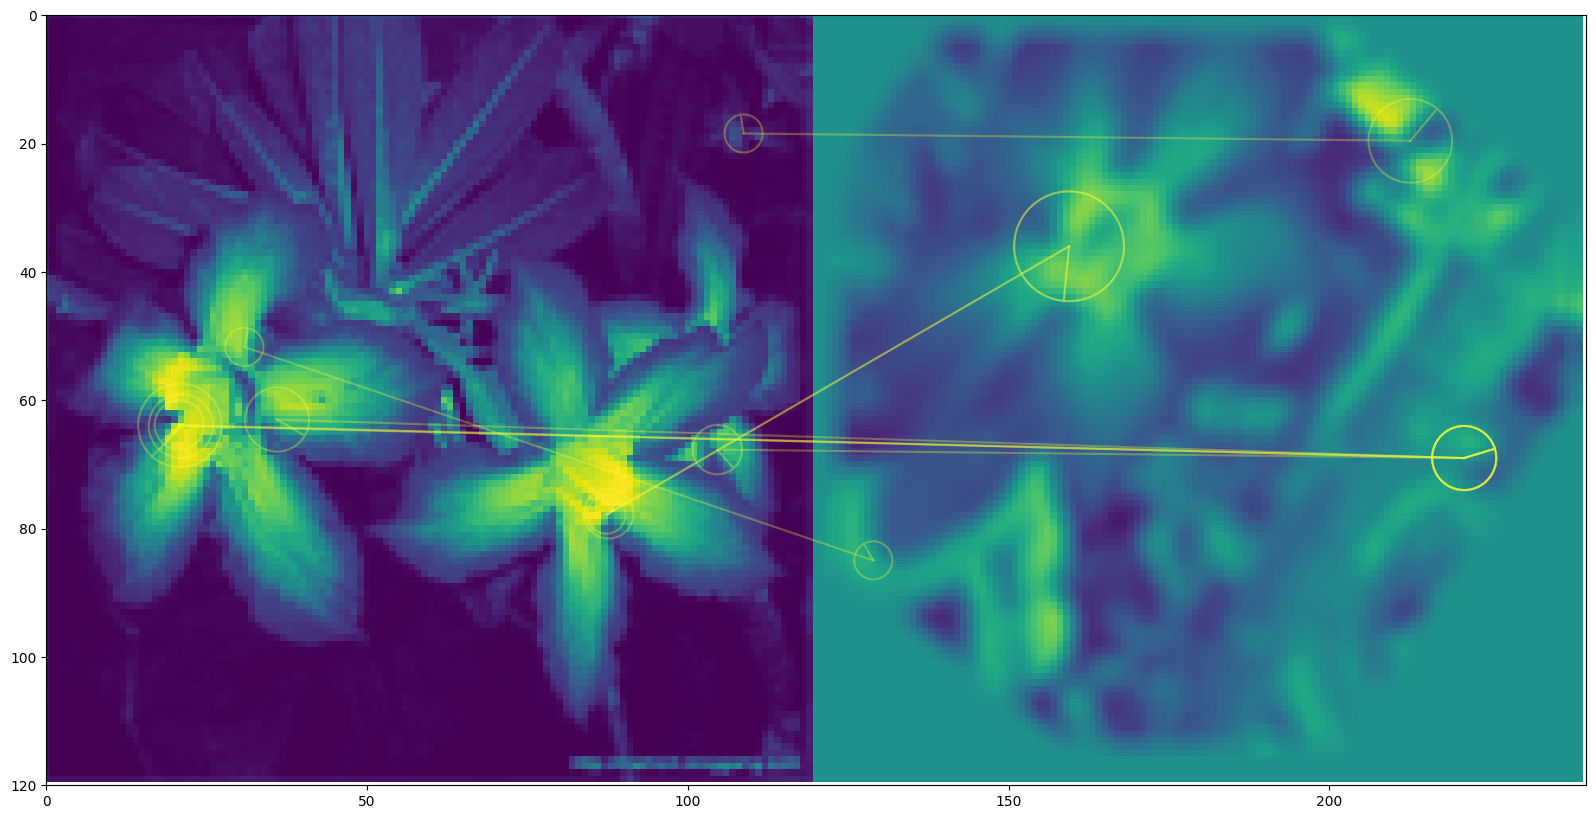

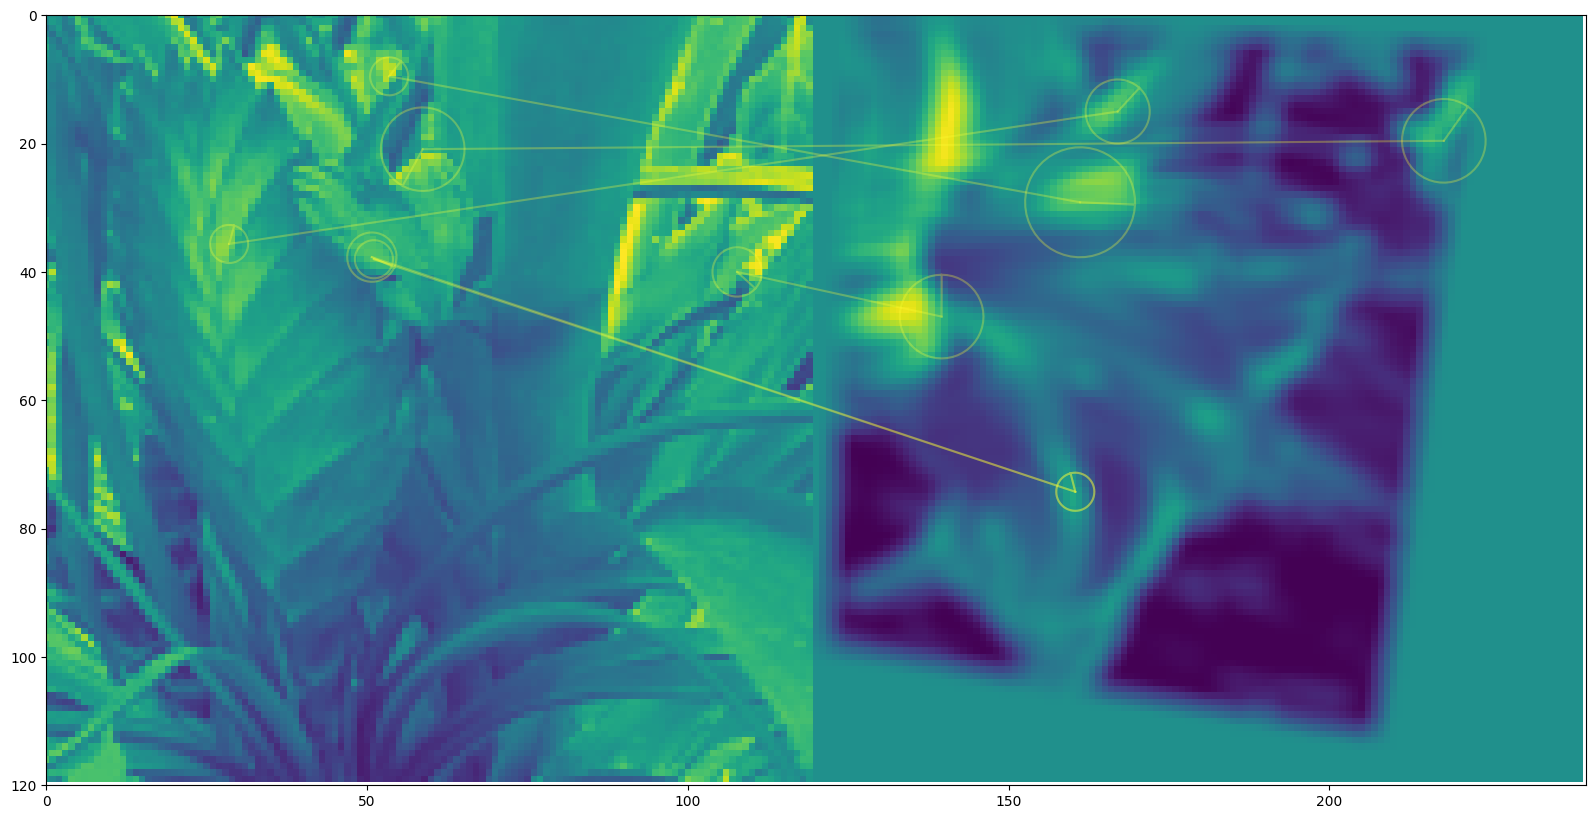

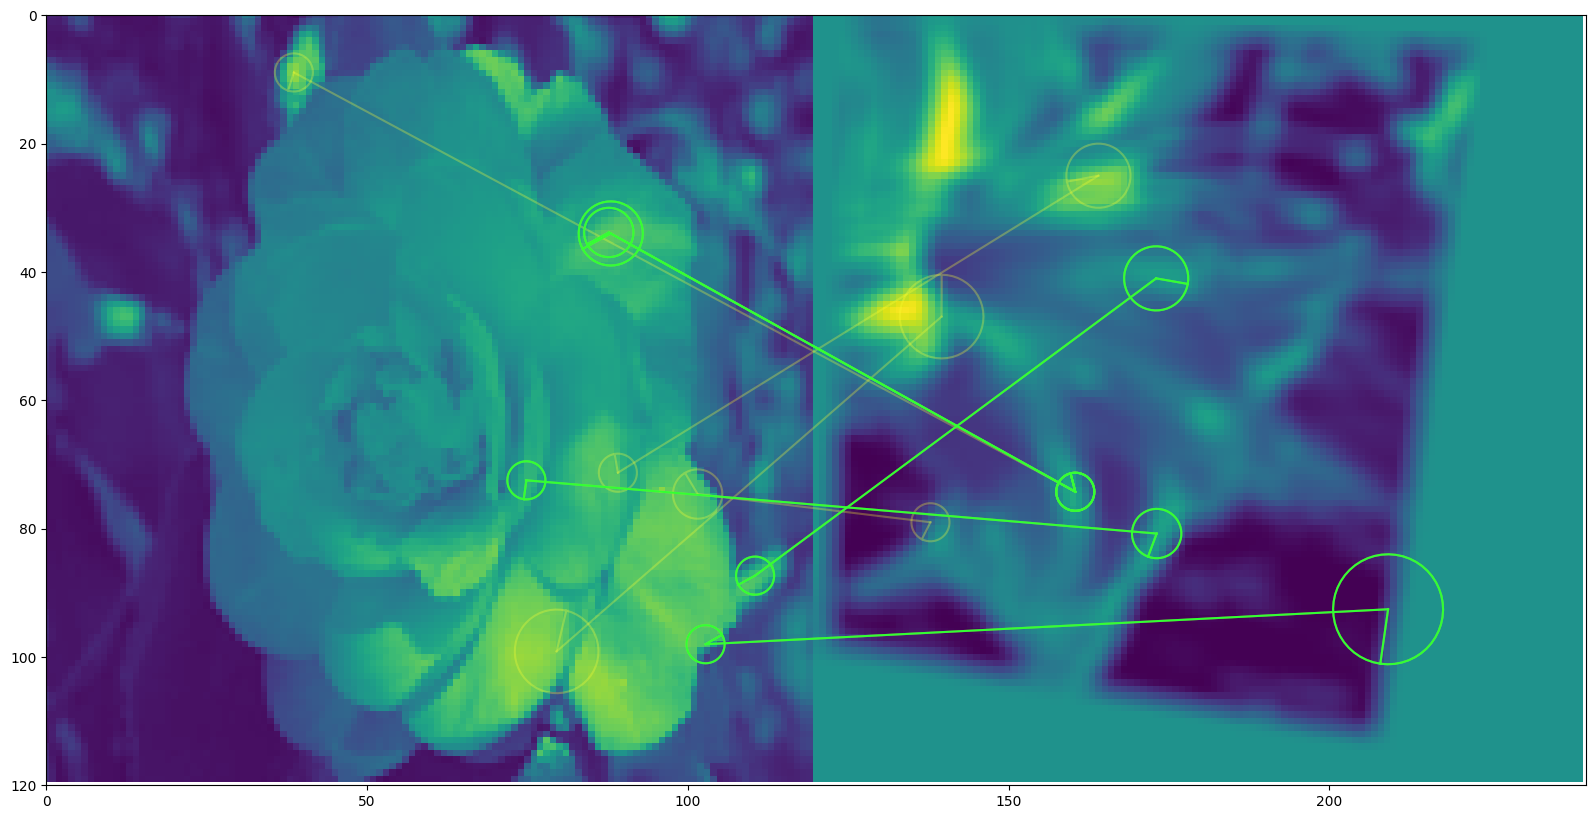

In [9]:
aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
    # kornia.augmentation.RandomEqualize(p=0.3),
    data_keys=["input"],#data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=True,
    # random_apply=15,
)

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(trainloader)
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(device)
    
    params_item = next(params_lists)
    timg_gray_t = aug_list(imgs_batch,params=params_item)
    repo_lafs_desc= detect_extract_feat_in_batch(timg_gray_t,detector,descriptor,PS)
        
    for i,img_gray in enumerate(imgs_batch):# itera em cada batch

        match_index = matching_imagens(img_gray,timg_gray_t,repo_lafs_desc)
        # print("match_index: ",match_index," i: ",i)
        total+=1
        if match_index == i:
            acertos += 1
        pbar.set_description(f"acertos/total: {acertos}/{total}  ")
print("acertos: ",acertos)